# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output  # draw progress bar

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans  # KMeans

from sklearn.model_selection import StratifiedShuffleSplit  # StratifiedShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostRegressor  # Adaptive Boosting
from xgboost.sklearn import XGBRegressor  # Extreme Gradient Boosting
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV  #Perforing grid search

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
N_JOBS = 4  # Number of parallel threads used to run xgboost and KMeans
DEBUG = True  # debug flag

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### What we want to do here ...
In this section, we will firet explore `Udacity_AZDIAS_052018.csv`, `Udacity_CUSTOMERS_052018.csv`, `DIAS Information Levels - Attributes 2017.xlsx`, and `DIAS Attributes - Values 2017.xlsx`. Analyze their relationship and summarize feature types, including binary categorical, nominal categorical, ordinal categorical, mixed categorical, or quantitative. Create fundamential data structure. And find some input error, such as typo, undocumentd, unknown values.

* Data Exploration - general population vs. customers
    - Analyze `Udacity_AZDIAS_052018.csv` and `Udacity_CUSTOMERS_052018.csv`.
* Data Exploration - attributes vs. values
    - Analyze `DIAS Information Levels - Attributes 2017.xlsx`, `DIAS Attributes - Values 2017.xlsx` and create feature types data structure.
* Data Exploration - customers vs. values
    - Analyze feature difference between `Udacity_CUSTOMERS_052018.csv` and `DIAS Attributes - Values 2017.xlsx`.
* Data Exploration - general population vs. customers (2nd)
    - Analyze feature difference between `Udacity_AZDIAS_052018.csv` and `Udacity_CUSTOMERS_052018.csv`
* Data Preprocessing
    - Create a `clean_data` function for data cleaning.

### Data Exploration - general population vs. customers
Analyze `Udacity_AZDIAS_052018.csv` and `Udacity_CUSTOMERS_052018.csv`.

#### Load general population and customers dataset

In [3]:
# load in the data
# general population dataset
azdias_df = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

# customers dataset
customers_df = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/fc/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [5]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


General population have 366 feature, and almost fall in the range between 0 and 200. Maybe have 6 mixed type columns

In [6]:
azdias_df.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


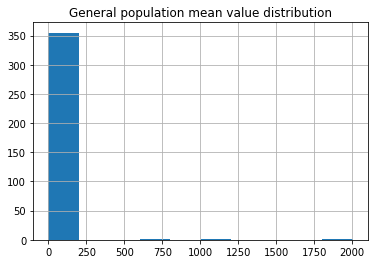

In [7]:
# almost all data are in the range between 0 and 200
azdias_df.drop('LNR', axis=1).describe().loc['mean'].hist()
plt.title('General population mean value distribution')
plt.show()

Customer have 369 feature, and almost fall in the range between 0 and 200.

In [8]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [9]:
customers_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [10]:
customers_df.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


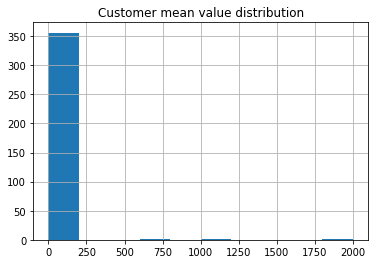

In [11]:
# almost all data are in the range between 0 and 200
customers_df.drop('LNR', axis=1).describe().loc['mean'].hist()
plt.title('Customer mean value distribution')
plt.show()

General population and customer have 366 common features.

In [12]:
np.intersect1d(azdias_df.columns.values, customers_df.columns.values).shape

(366,)

create `only_attr_customers` to hold `customer_df` only features

In [13]:
only_attr_customers = np.setdiff1d(customers_df.columns.values, azdias_df.columns.values)
only_attr_customers

array(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype=object)

CUSTOMER_GROUP distribution

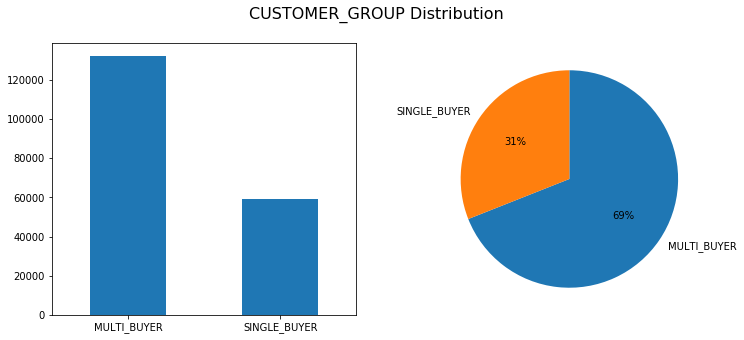

In [14]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
customers_df.CUSTOMER_GROUP.value_counts().plot.bar(rot=0)

plt.subplot(1, 2, 2)
customers_df.CUSTOMER_GROUP.value_counts().plot.pie(autopct='%1.f%%', startangle = 90, counterclock = False).set_ylabel('')

plt.suptitle('CUSTOMER_GROUP Distribution', fontsize=16)
plt.show()

ONLINE_PURCHASE distribution

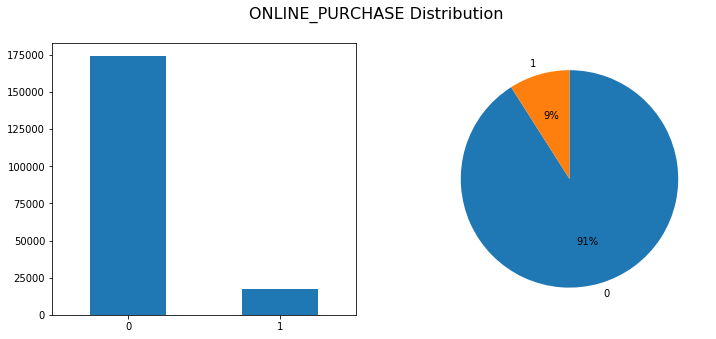

In [15]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
customers_df.ONLINE_PURCHASE.value_counts().plot.bar(rot=0)

plt.subplot(1, 2, 2)
customers_df.ONLINE_PURCHASE.value_counts().plot.pie(autopct='%1.f%%', startangle = 90, counterclock = False).set_ylabel('')

plt.suptitle('ONLINE_PURCHASE Distribution', fontsize=16)
plt.show()

__NOTE__: customers don't like online purchase.

PRODUCT_GROUP distribution

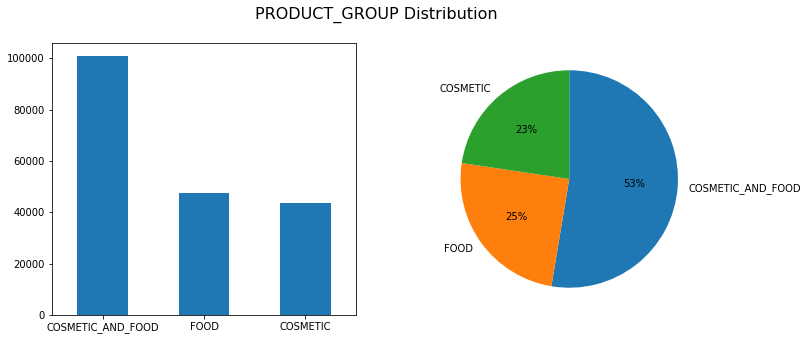

In [16]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
customers_df.PRODUCT_GROUP.value_counts().plot.bar(rot=0)

plt.subplot(1, 2, 2)
customers_df.PRODUCT_GROUP.value_counts().plot.pie(autopct='%1.f%%', startangle = 90, counterclock = False).set_ylabel('')

plt.suptitle('PRODUCT_GROUP Distribution', fontsize=16)
plt.show()

### Data Exploration - attributes vs. values
Analyze `DIAS Information Levels - Attributes 2017.xlsx`, `DIAS Attributes - Values 2017.xlsx` and create feature types data structure.

#### Load attributes dataset

In [17]:
# attributes dataset
attributes_df = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1, index_col=[1]).reset_index()
del attributes_df['Unnamed: 0']
attributes_df.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [18]:
attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
Information level    312 non-null object
Attribute            313 non-null object
Description          313 non-null object
Additional notes     20 non-null object
dtypes: object(4)
memory usage: 9.9+ KB


#### Load values dataset

In [19]:
# values dataset
values_df = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1, index_col=[1,2]).reset_index()
del values_df['Unnamed: 0']
values_df.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [20]:
values_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
Attribute      2258 non-null object
Description    2258 non-null object
Value          2258 non-null object
Meaning        2247 non-null object
dtypes: object(4)
memory usage: 70.6+ KB


In [21]:
# values_df only
np.setdiff1d(values_df.Attribute.unique(), attributes_df.Attribute)

array(['BIP_FLAG', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_LOTTO_RZ',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSAND_ANZ_12',
       'D19_VERSAND_ANZ_24', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'KBA13_CCM_3000', 'KBA13_CCM_3001'], dtype=object)

In [22]:
# attributes_df only
np.setdiff1d(attributes_df.Attribute, values_df.Attribute.unique())

array(['ARBEIT', 'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24',
       'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24',
       'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24',
       'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24',
       'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24',
       'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM', 'EINWOHNER', 'GKZ', 'PLZ', 'PLZ8'],
      dtype=object)

From above, we can find attributes dataset features not normalized. We will use values dataset to query data, and merge attributes dataset feature to values.

Create `attr_only_attributes_not_values` to hold features only in `attributes_df` and not in `values_df`.

In [23]:
attr_only_attributes_not_values = np.array(['ARBEIT', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'EINWOHNER', 'GKZ', 'PLZ', 'PLZ8'])

creqte `annot_attribute` as combined features from `vlaues_df` and `attributes_df`.

In [24]:
annot_attribute = np.union1d(values_df.Attribute.unique(), attr_only_attributes_not_values)

In [25]:
annot_attribute.size

322

We found `only_attr_customers` not in `annot_attribute`

In [26]:
np.isin(only_attr_customers, values_df.Attribute)

array([False, False, False])

#### Analyze feature type

After analyze 'DIAS Information Levels - Attributes 2017.xls' and 'DIAS Attributes - Values 2017.xlsx', xWe create below variable to hold different type of features.

| variable                   | feature type                        |
|----------------------------|-------------------------------------|
| `bin_cat_annot_attribute`  | documented binary categor feature   |
| `nom_cat_annot_attribute`  | documented nominal category feature |
| `ord_cat_annot_attribute`  | documented ordinal category feature |
| `mix_cat_annot_attribute`  | documented mixed caztegory feature  |
| `num_annot_attribute`      | documented quantitative feature     |
| `unused_annot_attribute`   | documented unused feature           |

In [27]:
# documented binary categor feature
bin_cat_annot_attribute = np.array(['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'VERS_TYP'])

# documented nominal category feature
nom_cat_annot_attribute = np.array(['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ',
       'ZABEOTYP', 'AGER_TYP', 'D19_KONSUMTYP', 'HEALTH_TYP'])

# documented ordinal category feature
ord_cat_annot_attribute = np.array(['ALTERSKATEGORIE_GROB', 'ALTER_HH', 'ARBEIT',
       'BALLRAUM', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12',
       'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12',
       'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12',
       'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM', 'EWDICHTE', 'FINANZ_ANLEGER',
       'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'GEBAEUDETYP_RASTER',
       'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_ALTER1',
       'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1', 'KBA05_CCM2',
       'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU',
       'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3',
       'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_HERSTTEMP',
       'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2',
       'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER',
       'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2',
       'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXHERST',
       'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD2',
       'KBA05_MOD3', 'KBA05_MOD4', 'KBA05_MOD8', 'KBA05_MODTEMP',
       'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG10',
       'KBA05_SEG2', 'KBA05_SEG3', 'KBA05_SEG4', 'KBA05_SEG5',
       'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9',
       'KBA05_VORB0', 'KBA05_VORB1', 'KBA05_VORB2', 'KBA05_ZUL1',
       'KBA05_ZUL2', 'KBA05_ZUL3', 'KBA05_ZUL4', 'KBA13_ALTERHALTER_30',
       'KBA13_ALTERHALTER_45', 'KBA13_ALTERHALTER_60',
       'KBA13_ALTERHALTER_61', 'KBA13_AUDI', 'KBA13_AUTOQUOTE',
       'KBA13_BJ_1999', 'KBA13_BJ_2000', 'KBA13_BJ_2004', 'KBA13_BJ_2006',
       'KBA13_BJ_2008', 'KBA13_BJ_2009', 'KBA13_BMW', 'KBA13_CCM_0_1400',
       'KBA13_CCM_1000', 'KBA13_CCM_1200', 'KBA13_CCM_1400',
       'KBA13_CCM_1500', 'KBA13_CCM_1600', 'KBA13_CCM_1800',
       'KBA13_CCM_2000', 'KBA13_CCM_2500', 'KBA13_CCM_2501',
       'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_FAB_ASIEN',
       'KBA13_FAB_SONSTIGE', 'KBA13_FIAT', 'KBA13_FORD',
       'KBA13_HALTER_20', 'KBA13_HALTER_25', 'KBA13_HALTER_30',
       'KBA13_HALTER_35', 'KBA13_HALTER_40', 'KBA13_HALTER_45',
       'KBA13_HALTER_50', 'KBA13_HALTER_55', 'KBA13_HALTER_60',
       'KBA13_HALTER_65', 'KBA13_HALTER_66', 'KBA13_HERST_ASIEN',
       'KBA13_HERST_AUDI_VW', 'KBA13_HERST_BMW_BENZ',
       'KBA13_HERST_EUROPA', 'KBA13_HERST_FORD_OPEL', 'KBA13_HERST_SONST',
       'KBA13_KMH_0_140', 'KBA13_KMH_110', 'KBA13_KMH_140',
       'KBA13_KMH_140_210', 'KBA13_KMH_180', 'KBA13_KMH_211',
       'KBA13_KMH_250', 'KBA13_KMH_251', 'KBA13_KRSAQUOT',
       'KBA13_KRSHERST_AUDI_VW', 'KBA13_KRSHERST_BMW_BENZ',
       'KBA13_KRSHERST_FORD_OPEL', 'KBA13_KRSSEG_KLEIN',
       'KBA13_KRSSEG_OBER', 'KBA13_KRSSEG_VAN', 'KBA13_KRSZUL_NEU',
       'KBA13_KW_0_60', 'KBA13_KW_110', 'KBA13_KW_120', 'KBA13_KW_121',
       'KBA13_KW_30', 'KBA13_KW_40', 'KBA13_KW_50', 'KBA13_KW_60',
       'KBA13_KW_61_120', 'KBA13_KW_70', 'KBA13_KW_80', 'KBA13_KW_90',
       'KBA13_MAZDA', 'KBA13_MERCEDES', 'KBA13_MOTOR', 'KBA13_NISSAN',
       'KBA13_OPEL', 'KBA13_PEUGEOT', 'KBA13_RENAULT',
       'KBA13_SEG_GELAENDEWAGEN', 'KBA13_SEG_GROSSRAUMVANS',
       'KBA13_SEG_KLEINST', 'KBA13_SEG_KLEINWAGEN',
       'KBA13_SEG_KOMPAKTKLASSE', 'KBA13_SEG_MINIVANS',
       'KBA13_SEG_MINIWAGEN', 'KBA13_SEG_MITTELKLASSE',
       'KBA13_SEG_OBEREMITTELKLASSE', 'KBA13_SEG_OBERKLASSE',
       'KBA13_SEG_SONSTIGE', 'KBA13_SEG_SPORTWAGEN',
       'KBA13_SEG_UTILITIES', 'KBA13_SEG_VAN', 'KBA13_SEG_WOHNMOBILE',
       'KBA13_SITZE_4', 'KBA13_SITZE_5', 'KBA13_SITZE_6', 'KBA13_TOYOTA',
       'KBA13_VORB_0', 'KBA13_VORB_1', 'KBA13_VORB_1_2', 'KBA13_VORB_2',
       'KBA13_VORB_3', 'KBA13_VW', 'KKK', 'KONSUMNAEHE', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'ORTSGR_KLS9',
       'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4',
       'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'REGIOTYP', 'RELAT_AB',
       'RETOURTYP_BK_S', 'SEMIO_DOM', 'SEMIO_ERL', 'SEMIO_FAM',
       'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST',
       'SEMIO_MAT', 'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL',
       'SEMIO_SOZ', 'SEMIO_TRADV', 'SEMIO_VERT', 'WOHNDAUER_2008',
       'W_KEIT_KIND_HH'])

# documented mixed caztegory feature
mix_cat_annot_attribute = np.array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE'])

# documented unused feature
num_annot_attribute = np.array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'])

In [28]:
num_annot_attribute.size + bin_cat_annot_attribute.size + nom_cat_annot_attribute.size + ord_cat_annot_attribute.size + mix_cat_annot_attribute.size

276

In [29]:
unused_annot_attribute = np.setdiff1d(annot_attribute, np.union1d(np.union1d(np.union1d(np.union1d(num_annot_attribute, bin_cat_annot_attribute), nom_cat_annot_attribute), ord_cat_annot_attribute), mix_cat_annot_attribute))

In [30]:
assert annot_attribute.size == num_annot_attribute.size + bin_cat_annot_attribute.size + nom_cat_annot_attribute.size + ord_cat_annot_attribute.size + mix_cat_annot_attribute.size + unused_annot_attribute.size

#### Analyze unknown value

list all possible unknown meaning string

In [31]:
values_df.loc[np.where(values_df.Meaning.str.contains('know'))].Meaning.unique()

array(['unknown', 'unknown / no main age detectable',
       'no transactions known', 'no transaction known',
       'residental building buildings without actually known household',
       'mixed building without actually known household or comapny ',
       'company building w/o known company ',
       'mixed building without actually known household ',
       'mixed building without actually known company ', nan],
      dtype=object)

We create below variable to hold different type of unknow value dataframe.

| variable                         | meaning                          |
|----------------------------------|----------------------------------|
| `unknown_values_df`              | unknown                          |
| `main_age_unknown_values_df`     | unknown / no main age detectable |
| `transactions_unknown_values_df` | no transactions know             |
| `transaction_unknown_values_df`  | no transaction known             |

In [32]:
# different type of unknow value dataframe
unknown_values_df = values_df[values_df.Meaning == 'unknown']
main_age_unknown_values_df = values_df[values_df.Meaning == 'unknown / no main age detectable']
transactions_unknown_values_df = values_df[values_df.Meaning == 'no transactions known']
transaction_unknown_values_df = values_df[values_df.Meaning == 'no transaction known']

### Data Exploration - customers vs. values
Analyze Udacity_CUSTOMERS_052018.csv and DIAS Attributes - Values 2017.xlsx.

#### COLUMN Veiewpoint

We create below variable to hold common features of `customers_df` and `annot_atribute`.

| variable                          |                                                          |
|-----------------------------------|----------------------------------------------------------|
| `annot_attr_customers_values`     | common features of `customer_df` and `annot_attribute`   |
| `not_annot_attr_customers_values` | distinct features of `customer_df` and `annot_attribute` |

In [33]:
annot_attr_customers_values = np.intersect1d(customers_df.columns.values, annot_attribute)
not_annot_attr_customers_values = np.setdiff1d(customers_df.columns.values, annot_attr_customers_values)

In [34]:
assert customers_df.columns.values.size == annot_attr_customers_values.size + not_annot_attr_customers_values.size

In [35]:
customers_df[annot_attr_customers_values].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 276 entries, AGER_TYP to ZABEOTYP
dtypes: float64(216), int64(57), object(3)
memory usage: 403.6+ MB


#### Check missing value

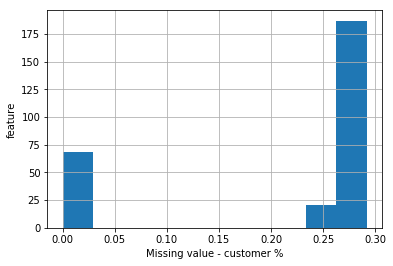

In [36]:
customers_df[annot_attr_customers_values].isnull().mean().hist()
plt.xlabel('Missing value - customer %')
plt.ylabel('feature')
plt.show()

We can find all customers have missing value among documented features are less than 30%.

__NOTE__: **We set `FEATURE_DROP_RATIO` as 70 % to drop feature.** (If missing value among feature over 70%, we will drop it.)

In [37]:
FEATURE_DROP_RATIO=.7

We create below variable to hold diffent type of feature in `customers_df`

| variable                            |                                                  |
|-------------------------------------|--------------------------------------------------|
| `customers_bin_cat_annot_attribute` | hold `bin_cat_annot_attribute` in `values_df`    |
| `customers_nom_cat_annot_attribute` | hold `nom_cat_annot_attribute` in `values_df`    |
| `customers_ord_cat_annot_attribute` | hold `ord_cat_annot_attribute` in `values_df`    |
| `customers_mix_cat_annot_attribute` | hold `mix_cat_annot_attribute` in `values_df`    |
| `customers_num_annot_attribute`     | hold `num_annot_attribute` in `values_df`        |
| `customers_unused_annot_attribute`  | hold unused features in `values_df`              |

In [38]:
customers_unused_annot_attribute = annot_attr_customers_values[customers_df[annot_attr_customers_values].isnull().mean() > FEATURE_DROP_RATIO]

In [39]:
customers_unused_annot_attribute.size

0

#### Check `customers_bin_cat_annot_attribute`

In [40]:
customers_bin_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, bin_cat_annot_attribute)
customers_bin_cat_annot_attribute = np.setdiff1d(customers_bin_cat_annot_attribute, customers_unused_annot_attribute)

In [41]:
customers_bin_cat_annot_attribute

array(['ANREDE_KZ', 'GREEN_AVANTGARDE', 'OST_WEST_KZ', 'VERS_TYP'],
      dtype=object)

In [42]:
# scan undocumented value
for col in customers_bin_cat_annot_attribute:
    v1 = customers_df[col].dropna().unique()
    if col == 'OST_WEST_KZ':
        v2 = values_df[values_df.Attribute == col]['Value'].dropna().apply(lambda x: np.nan if x == -1 else x).dropna().values
    else:
        v2 = np.hstack(values_df[values_df.Attribute == col]['Value'].dropna().apply(lambda x: x if not isinstance(x, str) else x.split(','))).astype(int)
    v = np.setdiff1d(v1, v2)
    if v.size > 0:
        print('{} feature has undocumented value: {}'.format(col, v))

#### Check `customers_nom_cat_annot_attribute`

In [43]:
customers_nom_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, nom_cat_annot_attribute)
customers_nom_cat_annot_attribute = np.setdiff1d(customers_nom_cat_annot_attribute, customers_unused_annot_attribute)

In [44]:
customers_nom_cat_annot_attribute

array(['AGER_TYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP',
       'D19_KONSUMTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP',
       'HEALTH_TYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'ZABEOTYP'],
      dtype=object)

In [45]:
# scan undocumented value
for col in customers_nom_cat_annot_attribute:
    
    unknown_v = []
    if col == 'CAMEO_DEUG_2015':
        v1 = customers_df[col].dropna().apply(lambda x: unknown_v.append(x) if isinstance(x, str) else int(x)).dropna().unique()
    else:
        v1 = customers_df[col].dropna().unique()

    if col == 'CAMEO_DEUG_2015' or col == 'CAMEO_DEU_2015':
        v2 = values_df[values_df.Attribute == col]['Value'].values
    else:
        v2 = np.hstack(values_df[values_df.Attribute == col]['Value'].dropna().apply(lambda x: x if not isinstance(x, str) else x.split(','))).astype(int)
    
    v = np.setdiff1d(v1, v2)
    unknown_v = np.unique(np.array(unknown_v))
    
    if len(unknown_v) > 0:
        print('{} feature has unknown value: {}'.format(col, unknown_v))
    if v.size > 0:
        print('{} feature has undocumented value: {}'.format(col, v))

CAMEO_DEUG_2015 feature has unknown value: ['1' '2' '3' '4' '5' '6' '7' '8' '9' 'X']
CAMEO_DEU_2015 feature has undocumented value: ['XX']
LP_FAMILIE_FEIN feature has undocumented value: [0.]
LP_FAMILIE_GROB feature has undocumented value: [0.]


#### Check `ord_cat_annot_attribute`

In [46]:
customers_ord_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, ord_cat_annot_attribute)
customers_ord_cat_annot_attribute = np.setdiff1d(customers_ord_cat_annot_attribute, customers_unused_annot_attribute)

In [47]:
customers_ord_cat_annot_attribute.size

246

In [48]:
# scan undocumented value
for col in customers_ord_cat_annot_attribute:

    unknown_v = []
    v1 = customers_df[col].dropna().apply(lambda x: unknown_v.append(x) if isinstance(x, str) else x).dropna().unique()

    # assue value of 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM' are as same as 'D19_BANKEN_DATUM'
    if col in ['D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM']:
        col = 'D19_BANKEN_DATUM'
    
    if values_df[values_df.Attribute == col].shape[0] > 0:
        v2 = np.hstack(values_df[values_df.Attribute == col]['Value'].apply(lambda x: list(map(int, x.split(','))) if isinstance(x, str) else x).values)
    else:
        v2 = np.array([])

    v = np.setdiff1d(v1, v2)
    unknown_v = np.unique(np.array(unknown_v))
    
    if len(unknown_v) > 0:
        print('{} feature has unknown value: {}'.format(col, unknown_v))
    if v.size > 0:
        print('{} feature has undocumented value: {}'.format(col, v))

ARBEIT feature has undocumented value: [1. 2. 3. 4. 5. 9.]
KBA05_MODTEMP feature has undocumented value: [6.]


#### Check `customers_mix_cat_annot_attribute`

In [49]:
customers_mix_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, mix_cat_annot_attribute)
customers_mix_cat_annot_attribute = np.setdiff1d(customers_mix_cat_annot_attribute, customers_unused_annot_attribute)

In [50]:
customers_mix_cat_annot_attribute

array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE'], dtype=object)

In [51]:
# scan undocumented value
for col in customers_mix_cat_annot_attribute:
    v1 = customers_df[col].dropna().unique()
    v2 = np.hstack(values_df[values_df.Attribute == col]['Value'].dropna().apply(lambda x: x if not isinstance(x, str) else x.split(','))).astype(int)
    v = np.setdiff1d(v1, v2)
    if v.size > 0:
        print('{} feature has undocumented value: {}'.format(col, v))

LP_LEBENSPHASE_FEIN feature has undocumented value: [0.]
LP_LEBENSPHASE_GROB feature has undocumented value: [0.]


#### Check `num_annot_attribute`

In [52]:
customers_num_annot_attribute = np.intersect1d(annot_attr_customers_values, num_annot_attribute)
customers_num_annot_attribute = np.setdiff1d(customers_num_annot_attribute, customers_unused_annot_attribute)

In [53]:
customers_num_annot_attribute

array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'],
      dtype=object)

In [54]:
# scan numeric type
for col in customers_num_annot_attribute:
    if not np.issubdtype(customers_df[col].dtype, np.number):
        print('{} is not numeric type'.format(col))

#### To fix the error, we will need to ...

1. CAMEO_DEUG_2015: **change '1', '2', '3', '4', '5', '6', '7', '8', '9' to integer, and 'X' to NA**
1. CAMEO_DEU_2015: **change 'XX' to NA**
1. KBA05_MODTEMP: **change 6 to NA**
1. LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB: **chagne 0 to NA**
1. All other attributes: **convert to integer**

In [55]:
assert annot_attr_customers_values.size == customers_bin_cat_annot_attribute.size \
                                            + customers_nom_cat_annot_attribute.size \
                                            + customers_ord_cat_annot_attribute.size \
                                            + customers_mix_cat_annot_attribute.size \
                                            + customers_num_annot_attribute.size \
                                            + customers_unused_annot_attribute.size

#### Check unknown value

We create below variable to hold diffent type of feature in unknown feature in `customers_df`

| variable                                |                                                                           |
|-----------------------------------------|---------------------------------------------------------------------------|
| `customers_unknown_values_df`              | hold 'unknown' meaning feature in `customers_df`                          |
| `customers_main_age_unknown_values_df`     | hold 'unknown / no main age detectable' meaning feature in `customers_df` |
| `customers_transactions_unknown_values_df` | hold 'no transactions known' meaning feature in `customers_df`            |
| `customers_transaction_unknown_values_df`  | hold 'no transaction known' meaning feature in `customers_df`             |

In [56]:
# create below dataframe to hold different type of unknown value
customers_unknown_values_df = unknown_values_df[np.isin(unknown_values_df.Attribute, np.setdiff1d(customers_df.columns, customers_unused_annot_attribute))]
customers_main_age_unknown_values_df = main_age_unknown_values_df[np.isin(main_age_unknown_values_df.Attribute, np.setdiff1d(customers_df.columns, customers_unused_annot_attribute))]
customers_transactions_unknown_values_df = transactions_unknown_values_df[np.isin(transactions_unknown_values_df.Attribute, np.setdiff1d(customers_df.columns, customers_unused_annot_attribute))]
customers_transaction_unknown_values_df = transaction_unknown_values_df[np.isin(transaction_unknown_values_df.Attribute.str[:-3], np.setdiff1d(customers_df.columns, customers_unused_annot_attribute))]
customers_transaction_unknown_values_df.Attribute = customers_transaction_unknown_values_df.Attribute.str[:-3]

/Users/fc/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


##### check `not_annot_attr_customers_values`

In [57]:
customers_df[not_annot_attr_customers_values].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 93 columns):
AKT_DAT_KL                    145056 non-null float64
ALTERSKATEGORIE_FEIN          139810 non-null float64
ALTER_KIND1                   11766 non-null float64
ALTER_KIND2                   5100 non-null float64
ALTER_KIND3                   1275 non-null float64
ALTER_KIND4                   236 non-null float64
ANZ_KINDER                    145056 non-null float64
ANZ_STATISTISCHE_HAUSHALTE    141725 non-null float64
CAMEO_INTL_2015               141224 non-null object
CJT_KATALOGNUTZER             188439 non-null float64
CJT_TYP_1                     188439 non-null float64
CJT_TYP_2                     188439 non-null float64
CJT_TYP_3                     188439 non-null float64
CJT_TYP_4                     188439 non-null float64
CJT_TYP_5                     188439 non-null float64
CJT_TYP_6                     188439 non-null float64
CUSTOMER_GROUP                1916

We create below variable to hold differennt type of undocumented features in `customers_df`.

| variable                                |                                                                   |
|-----------------------------------------|-------------------------------------------------------------------|
| `customers_bin_cat_not_annot_attribute` | hold undocumented binary category feature in `customers_df`       |
| `customers_nom_cat_not_annot_attribute` | hold undocumented nominal category feature in `customers_df`      |
| `customers_ord_cat_not_annot_attribute` | hold undocumented ordinal categroy feature in `customers_df`      |
| `customers_mix_cat_not_annot_attribute` | hold undocumented mixed category feature in `customers_df`        |
| `customers_num_not_annot_attribute`     | hold undocumented quantative feature in `customers_df`            |
| `customers_unused_not_annot_attribute`  | hold undocumented unused feature in `customers_df`                |

In [58]:
# undocumented binary category feature
customers_bin_cat_not_annot_attribute = np.array(['DSL_FLAG', 'HH_DELTA_FLAG', 'KONSUMZELLE', 'SOHO_KZ'])

# undocumented nominal category feature
customers_nom_cat_not_annot_attribute = np.array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'EXTSEL992',
       'GEMEINDETYP', 'VERDICHTUNGSRAUM', 'VK_DHT4A'])

# undocumented ordinal categroy feature
customers_ord_cat_not_annot_attribute = np.array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'CJT_KATALOGNUTZER',
       'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5',
       'CJT_TYP_6', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
       'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO',
       'D19_BUCH_CD', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL',
       'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_HANDWERK',
       'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX',
       'D19_KOSMETIK', 'D19_LEBENSMITTEL', 'D19_LOTTO',
       'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN',
       'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES',
       'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_TELKO_ONLINE_QUOTE_12',
       'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_REST',
       'D19_VERSICHERUNGEN', 'D19_VERSI_ONLINE_QUOTE_12',
       'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'EINGEZOGENAM_HH_JAHR',
       'FIRMENDICHTE', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3',
       'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_2500', 'KBA13_GBZ',
       'KBA13_HHZ', 'KBA13_KMH_210', 'KK_KUNDENTYP', 'KOMBIALTER', 'LNR',
       'MOBI_RASTER', 'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN',
       'RT_UEBERGROESSE', 'STRUKTURTYP', 'UMFELD_ALT', 'UMFELD_JUNG',
       'UNGLEICHENN_FLAG', 'VHA', 'VHN', 'VK_DISTANZ', 'VK_ZG11', 'ANZ_KINDER'])

# undocumented mixed category feature
customers_mix_cat_not_annot_attribute = np.array(['CAMEO_INTL_2015'])

# undocumented quantative feature
customers_num_not_annot_attribute = np.array(['ANZ_STATISTISCHE_HAUSHALTE'])

# undocumented unused feature
customers_unused_not_annot_attribute = only_attr_customers

In [59]:
assert not_annot_attr_customers_values.size == customers_bin_cat_not_annot_attribute.size \
                                                + customers_nom_cat_not_annot_attribute.size \
                                                + customers_ord_cat_not_annot_attribute.size \
                                                + customers_mix_cat_not_annot_attribute.size \
                                                + customers_num_not_annot_attribute.size \
                                                + customers_unused_not_annot_attribute.size

#### Check missing value

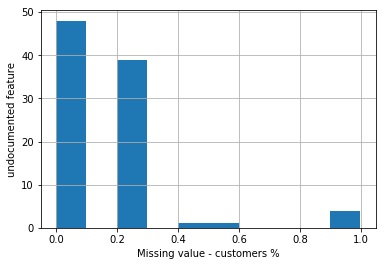

In [60]:
customers_df[not_annot_attr_customers_values].isnull().mean().hist()
plt.xlabel('Missing value - customers %')
plt.ylabel('undocumented feature')
plt.show()

We can find over 70% csutomers still have missing value among about 4 undocumented features.

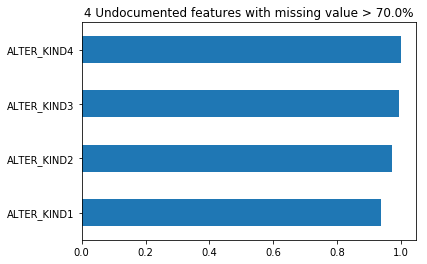

In [61]:
_ = not_annot_attr_customers_values[customers_df[not_annot_attr_customers_values].isnull().mean() > FEATURE_DROP_RATIO]
customers_df[_].isnull().mean().plot.barh()
plt.title('{} Undocumented features with missing value > {}%'.format(_.size, FEATURE_DROP_RATIO*100))
plt.show()

In [62]:
customers_unused_not_annot_attribute = np.union1d(customers_unused_not_annot_attribute, not_annot_attr_customers_values[customers_df[not_annot_attr_customers_values].isnull().mean() > FEATURE_DROP_RATIO])

In [63]:
customers_unused_not_annot_attribute

array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype=object)

#### Ananlyze EINGEFUEGT_AM

convert datetime string to unix second integer

In [64]:
pd.to_datetime(customers_df['EINGEFUEGT_AM']).describe()

count                  141725
unique                   3034
top       1992-02-10 00:00:00
freq                    64744
first     1992-02-10 00:00:00
last      2016-07-05 00:00:00
Name: EINGEFUEGT_AM, dtype: object

__NOTE__: We will convert datetime string to year based categorical feature

#### Analyze D19_LETZTER_KAUF_BRANCHE

convert string to column index

In [65]:
customers_df['D19_LETZTER_KAUF_BRANCHE'].describe()

count            143955
unique               35
top       D19_UNBEKANNT
freq              31910
Name: D19_LETZTER_KAUF_BRANCHE, dtype: object

In [66]:
customers_df[customers_df['D19_LETZTER_KAUF_BRANCHE'].notna()]['D19_LETZTER_KAUF_BRANCHE'].apply(lambda x: np.where(customers_df.columns == x)[0][0] if x != 'D19_UNBEKANNT' else 0).unique()

array([ 0, 32, 63, 67, 42, 44, 68, 70, 93, 74, 94, 55, 45, 65, 33, 86, 39,
       46, 38, 78, 66, 31, 56, 37, 60, 47, 54, 64, 43, 41, 40, 95, 79, 62,
       59])

__NOTE__: We will change feature string to column index.

#### Analyze CAMEO_INTL_2015

In [67]:
# scan value distribution
int_v = []
v1 = customers_df['CAMEO_INTL_2015'].dropna().apply(lambda x: int_v.append(x) if isinstance(x, int) else x).dropna().unique()

float_v = []
v1 = customers_df['CAMEO_INTL_2015'].dropna().apply(lambda x: float_v.append(x) if isinstance(x, float) else x).dropna().unique()

str_v = []
v1 = customers_df['CAMEO_INTL_2015'].dropna().apply(lambda x: str_v.append(x) if isinstance(x, str) else x).dropna().unique()

int_v = np.unique(np.array(int_v))
float_v = np.unique(np.array(float_v))
str_v = np.unique(np.array(str_v))

if len(int_v) > 0:
    print('CAMEO_INTL_2015 feature has int value: {}'.format(int_v))
if len(float_v) > 0:
    print('CAMEO_INTL_2015 feature has float value: {}'.format(float_v))
if len(str_v) > 0:
    print('CAMEO_INTL_2015 feature has string value: {}'.format(str_v))

CAMEO_INTL_2015 feature has float value: [12. 13. 14. 15. 22. 23. 24. 25. 31. 32. 33. 34. 35. 41. 43. 44. 45. 51.
 52. 54. 55.]
CAMEO_INTL_2015 feature has string value: ['12' '13' '14' '15' '22' '23' '24' '25' '31' '32' '33' '34' '35' '41'
 '43' '44' '45' '51' '52' '54' '55' 'XX']


__NOTE__: CAMEO_INTL_2015 combines information on two axes: wealth and life stage. I will break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables.

LNR is like serial number

In [68]:
customers_df.shape[0] == customers_df['LNR'].unique().size

True

In [69]:
customers_unused_not_annot_attribute = np.union1d(customers_unused_not_annot_attribute, 'LNR')
customers_ord_cat_not_annot_attribute = np.setdiff1d(customers_ord_cat_not_annot_attribute, 'LNR')

#### To fix the error, we will need to ...

1. ONLINE_PURCHASE, CUSTOMER_GROUP, PRODUCT_GROUP: **drop (not exist in general population)**
1. ALTER_KIND1, ALTER_KIND2, ALTER_KIND3, ALTER_KIND4: **drop (missing value > 70%)**
1. EINGEFUEGT_AM: **convert datetime string to year based categorical feature**
1. D19_LETZTER_KAUF_BRANCHE: **change feature string to column index**
1. CAMEO_INTL_2015: **change '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35', '23', '12', '44', '41', '52', '31', '13', '34', '32', '33' to integer, and 'XX' to NA. Combines information on two axes: wealth and life stage. I will break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables.**
1. LNR: **will move it as index to preserve information for segmentation and modeling usage**
1. All other attribute: **convert to integer**

In [70]:
customers_bin_cat_not_annot_attribute = np.setdiff1d(customers_bin_cat_not_annot_attribute, customers_unused_not_annot_attribute)
customers_nom_cat_not_annot_attribute = np.setdiff1d(customers_nom_cat_not_annot_attribute, customers_unused_not_annot_attribute)
customers_ord_cat_not_annot_attribute = np.setdiff1d(customers_ord_cat_not_annot_attribute, customers_unused_not_annot_attribute)
customers_mix_cat_not_annot_attribute = np.setdiff1d(customers_mix_cat_not_annot_attribute, customers_unused_not_annot_attribute)
customers_num_not_annot_attribute = np.setdiff1d(customers_num_not_annot_attribute, customers_unused_not_annot_attribute)

In [71]:
assert not_annot_attr_customers_values.size == customers_bin_cat_not_annot_attribute.size \
                                                + customers_nom_cat_not_annot_attribute.size \
                                                + customers_ord_cat_not_annot_attribute.size \
                                                + customers_mix_cat_not_annot_attribute.size \
                                                + customers_num_not_annot_attribute.size \
                                                + customers_unused_not_annot_attribute.size

In [72]:
customers_unused_not_annot_attribute

array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'CUSTOMER_GROUP', 'LNR', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],
      dtype=object)

#### ROW Viewpoint

#### Check missing value

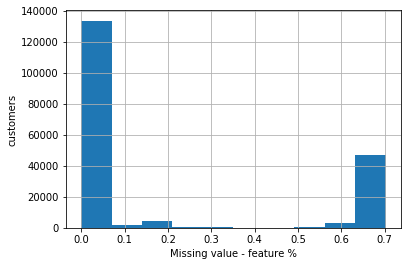

In [73]:
customers_df.isnull().mean(axis=1).hist()
plt.xlabel('Missing value - feature %')
plt.ylabel('customers')
plt.show()

### Data Exploration - general population vs. customers (2nd)
Analyze feature difference between `Udacity_AZDIAS_052018.csv` and `Udacity_CUSTOMERS_052018.csv`

In [74]:
azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


#### Check missing value

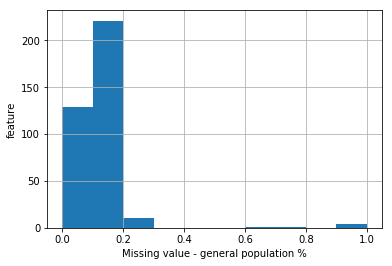

In [75]:
azdias_df.isnull().mean().hist()
plt.xlabel('Missing value - general population %')
plt.ylabel('feature')
plt.show()

Over 70% general population have around 4 feature have missing value.


We create below variable to hold differennt type of documented features in general population.

| variable                         |                                                                |
|----------------------------------|----------------------------------------------------------------|
| `annot_attr_azdias_values`       | to hold below all documented features in general population    |
| `azdias_bin_cat_annot_attribute` | hold `customers_bin_cat_annot_attribute` in general population |
| `azdias_nom_cat_annot_attribute` | hold `customers_nom_cat_annot_attribute` in general population |
| `azdias_ord_cat_annot_attribute` | hold `customers_ord_cat_annot_attribute` in general population |
| `azdias_mix_cat_annot_attribute` | hold `customers_mix_cat_annot_attribute` in general population |
| `azdias_num_annot_attribute`     | hold `customers_num_annot_attribute` in general population     |
| `azdias_unused_annot_attribute`  | hold `customers_unused_annot_attribute` in general population  |

We create below variable to hold differennt type of undocumented features in general population.

| variable                             |                                                                    |
|--------------------------------------|--------------------------------------------------------------------|
| `not_annot_attr_azdias_values`       | hold below all undocumented features in general population         |
| `azdias_bin_cat_not_annot_attribute` | hold `customers_bin_cat_not_annot_attribute` in general population |
| `azdias_nom_cat_not_annot_attribute` | hold `customers_nom_cat_not_annot_attribute` in general population |
| `azdias_ord_cat_not_annot_attribute` | hold `customers_ord_cat_not_annot_attribute` in general population |
| `azdias_mix_cat_not_annot_attribute` | hold `customers_mix_cat_not_annot_attribute` in general population |
| `azdias_num_not_annot_attribute`     | hold `customers_num_not_annot_attribute` in general population     |
| `azdias_unused_not_annot_attribute`  | hold `customers_unused_not_annot_attribute` in general population  |

In [76]:
annot_attr_azdias_values = annot_attr_customers_values
not_annot_attr_azdias_values = np.setdiff1d(not_annot_attr_customers_values, only_attr_customers)

In [77]:
assert annot_attr_azdias_values.size + not_annot_attr_azdias_values.size == customers_df.columns.size - only_attr_customers.size

In [78]:
# calculate all type of documented feature
azdias_unused_annot_attribute = np.intersect1d(azdias_df.columns[azdias_df.isnull().mean() > FEATURE_DROP_RATIO].values, annot_attr_azdias_values)
azdias_unused_annot_attribute = np.union1d(azdias_unused_annot_attribute, customers_unused_annot_attribute)
azdias_bin_cat_annot_attribute = np.setdiff1d(customers_bin_cat_annot_attribute, azdias_unused_annot_attribute)
azdias_nom_cat_annot_attribute = np.setdiff1d(customers_nom_cat_annot_attribute, azdias_unused_annot_attribute)
azdias_ord_cat_annot_attribute = np.setdiff1d(customers_ord_cat_annot_attribute, azdias_unused_annot_attribute)
azdias_mix_cat_annot_attribute = np.setdiff1d(customers_mix_cat_annot_attribute, azdias_unused_annot_attribute)
azdias_num_annot_attribute = np.setdiff1d(customers_num_annot_attribute, azdias_unused_annot_attribute)
azdias_unused_annot_attribute

array([], dtype=object)

In [79]:
assert annot_attr_azdias_values.size == azdias_bin_cat_annot_attribute.size \
                                        + azdias_nom_cat_annot_attribute.size \
                                        + azdias_ord_cat_annot_attribute.size \
                                        + azdias_mix_cat_annot_attribute.size \
                                        + azdias_num_annot_attribute.size \
                                        + azdias_unused_annot_attribute.size

In [80]:
# calculate all type of undocumented feature
azdias_unused_not_annot_attribute = np.intersect1d(azdias_df.columns[azdias_df.isnull().mean() > FEATURE_DROP_RATIO].values, not_annot_attr_azdias_values)
azdias_unused_not_annot_attribute = np.union1d(azdias_unused_not_annot_attribute, customers_unused_not_annot_attribute)
azdias_unused_not_annot_attribute = np.setdiff1d(azdias_unused_not_annot_attribute, only_attr_customers)
azdias_bin_cat_not_annot_attribute = np.setdiff1d(customers_bin_cat_not_annot_attribute, azdias_unused_not_annot_attribute)
azdias_nom_cat_not_annot_attribute = np.setdiff1d(customers_nom_cat_not_annot_attribute, azdias_unused_not_annot_attribute)
azdias_ord_cat_not_annot_attribute = np.setdiff1d(customers_ord_cat_not_annot_attribute, azdias_unused_not_annot_attribute)
azdias_mix_cat_not_annot_attribute = np.setdiff1d(customers_mix_cat_not_annot_attribute, azdias_unused_not_annot_attribute)
azdias_num_not_annot_attribute = np.setdiff1d(customers_num_not_annot_attribute, azdias_unused_not_annot_attribute)
azdias_unused_not_annot_attribute

array(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'EXTSEL992', 'LNR'], dtype=object)

In [81]:
assert not_annot_attr_azdias_values.size == azdias_bin_cat_not_annot_attribute.size \
                                            + azdias_nom_cat_not_annot_attribute.size \
                                            + azdias_ord_cat_not_annot_attribute.size \
                                            + azdias_mix_cat_not_annot_attribute.size \
                                            + azdias_num_not_annot_attribute.size \
                                            + azdias_unused_not_annot_attribute.size

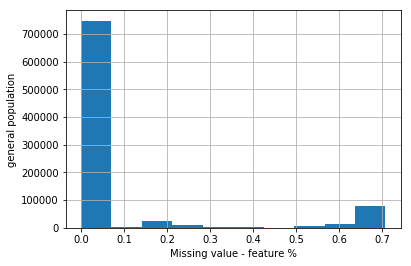

In [82]:
azdias_df.isnull().mean(axis=1).hist()
plt.xlabel('Missing value - feature %')
plt.ylabel('general population')
plt.show()

We need to **check general population value can cover customers**.

#### Ananlyze `azdias_bin_cat_annot_attribute`

Every category should exist in general population.

In [83]:
# scan general population and customer value coverage
for col in azdias_bin_cat_annot_attribute:
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        print('{} different only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customers_df : {}'.format(col, diff_customers_v))  

#### Ananlyze `azdias_nom_cat_annot_attribute`

Every category should exist in general population.

In [84]:
# scan general population and customer value coverage
for col in azdias_nom_cat_annot_attribute:

    str_azdias_v = []
    str_customers_v = []
    
    if col == 'CAMEO_DEUG_2015':
        
        azdias_v = azdias_df[col].dropna().apply(lambda x: str_azdias_v.append(x) if isinstance(x, str) else int(x)).dropna().unique()
        customers_v = customers_df[col].dropna().apply(lambda x: str_customers_v.append(x) if isinstance(x, str) else int(x)).dropna().unique()
        diff_str_azdias_v = np.setdiff1d(str_azdias_v, str_customers_v)
        diff_str_customers_v = np.setdiff1d(str_customers_v, str_azdias_v)
        str_azdias_v = np.unique(str_azdias_v)
        str_customers_v = np.unique(str_customers_v)
        str_azdias_v = []
        str_customers_v = []
    else:
        
        azdias_v = azdias_df[col].dropna().unique()
        customers_v = customers_df[col].dropna().unique()
    
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        
        true_v =  np.hstack(values_df[values_df.Attribute == col]['Value'].apply(lambda x: list(map(int, x.split(','))) if isinstance(x, str) else x).values)
        diff_diff_azdias_v = np.setdiff1d(diff_azdias_v, true_v)
        if diff_diff_azdias_v.size > 0:
            print('{} only in gnneral population : {} <- undocumented'.format(col, diff_diff_azdias_v))
        else:
            print('{} only in gnneral population : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customer : {}'.format(col, diff_customers_v))
    if len(str_azdias_v) > 0:
        print('{} only in general population : {}'.format(col, diff_str_azdias_v))
    if len(str_customers_v) > 0:
        print('{} only in customer : {}'.format(col, diff_str_customers_v))

GEBAEUDETYP only in gnneral population : [5.]
TITEL_KZ only in gnneral population : [2.]


#### Ananlyze `azdias_ord_cat_annot_attribute`

Every category should exist in general population.

In [85]:
# scan general population and customer value coverage
for col in azdias_ord_cat_annot_attribute:
    
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()
    
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        
        true_v =  np.hstack(values_df[values_df.Attribute == col]['Value'].apply(lambda x: list(map(int, x.split(','))) if isinstance(x, str) else x).values)
        diff_diff_azdias_v = np.setdiff1d(diff_azdias_v, true_v)
        if diff_diff_azdias_v.size > 0:
            print('{} only in gnneral population : {} <- undocumented'.format(col, diff_diff_azdias_v))
        else:
            print('{} only in gnneral population : {}'.format(col, diff_azdias_v))
    
    if diff_customers_v.size > 0:
        print('{} only in customer : {}'.format(col, diff_customers_v))

ALTER_HH only in gnneral population : [1.]
D19_BANKEN_ONLINE_QUOTE_12 only in gnneral population : [1.]
KBA05_GBZ only in customer : [0.]
KBA13_AUTOQUOTE only in gnneral population : [0.]
KBA13_KRSAQUOT only in gnneral population : [0.]
KBA13_KRSHERST_AUDI_VW only in gnneral population : [0.]
KBA13_KRSHERST_BMW_BENZ only in gnneral population : [0.]
KBA13_KRSHERST_FORD_OPEL only in gnneral population : [0.]
KBA13_KRSSEG_KLEIN only in gnneral population : [0.]
ORTSGR_KLS9 only in gnneral population : [0.] <- undocumented


__NOTE__: KBA05_GBZ = 0 is unknown, we will drop in data preprocessing stage. (We only care about **only in customer** value)

#### Ananlyze `azdias_mix_cat_annot_attribute`

Every category should exist in general population.

In [86]:
# scan general population and customer value coverage
for col in azdias_mix_cat_annot_attribute:
    
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()
    
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        print('{} different only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customers_df : {}'.format(col, diff_customers_v))

#### Ananlyze `azdias_num_annot_attribute`

Gnneral population range should cover customer.

In [87]:
# scan general population and customer value coverage
for col in azdias_num_annot_attribute:

    min_v1 = azdias_df[col].min()
    max_v1 = azdias_df[col].max()
    min_v2 = customers_df[col].min()
    max_v2 = customers_df[col].max()
    
    if min_v1 > min_v2:
        print('{} in azdias have min value: {} larger than customer: {}'.format(col, min_v1, min_v2))
    if max_v1 < max_v2:
        print('{} in azdias have max value: {} smaller than customer: {}'.format(col, min_v1, min_v2))

#### Ananlyze `azdias_bin_cat_not_annot_attribute`

Every category should exist in general population.

In [88]:
# scan general population and customer value coverage
for col in azdias_bin_cat_not_annot_attribute:
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        print('{} different only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customers_df : {}'.format(col, diff_customers_v))  

#### Ananlyze `azdias_nom_cat_not_annot_attribute`

Every category should exist in general population.

In [89]:
# scan general population and customer value coverage
for col in azdias_nom_cat_not_annot_attribute:
        
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()
    
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        print('{} different only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customers_df : {}'.format(col, diff_customers_v))

EINGEFUEGT_AM different only in azdias : ['1991-06-17 00:00:00' '1991-08-30 00:00:00' '1992-12-17 00:00:00' ...
 '2016-04-20 00:00:00' '2016-05-02 00:00:00' '2016-05-09 00:00:00']
EINGEFUEGT_AM different only in customers_df : ['1993-04-29 00:00:00' '1993-06-02 00:00:00' '1994-09-29 00:00:00'
 '1997-09-15 00:00:00' '1997-12-12 00:00:00' '1998-11-07 00:00:00'
 '1998-11-13 00:00:00' '1999-02-19 00:00:00' '1999-03-16 00:00:00'
 '1999-08-16 00:00:00' '1999-10-25 00:00:00' '2000-12-01 00:00:00'
 '2001-01-02 00:00:00' '2001-01-17 00:00:00' '2001-01-18 00:00:00'
 '2001-03-14 00:00:00' '2001-12-04 00:00:00' '2002-04-26 00:00:00'
 '2003-01-20 00:00:00' '2003-06-28 00:00:00' '2003-12-06 00:00:00'
 '2004-06-12 00:00:00' '2005-05-28 00:00:00' '2005-08-08 00:00:00'
 '2005-10-06 00:00:00' '2006-06-09 00:00:00' '2006-07-01 00:00:00'
 '2006-07-16 00:00:00' '2006-11-10 00:00:00' '2006-12-17 00:00:00'
 '2006-12-23 00:00:00' '2007-03-20 00:00:00' '2007-03-25 00:00:00'
 '2007-03-28 00:00:00' '2007-05-03 0

#### Ananlyze `azdias_ord_cat_not_annot_attribute`

Every category should exist in general population.

In [90]:
# scan general population and customer value coverage
for col in azdias_ord_cat_not_annot_attribute:
    azdias_v = azdias_df[col].dropna().unique()
    customers_v = customers_df[col].dropna().unique()

    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:

        print('{} only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        
        print('{} only in customers_df : {}'.format(col, diff_customers_v))

ALTERSKATEGORIE_FEIN only in azdias : [1.]
ANZ_KINDER only in azdias : [ 9. 11.]
D19_TELKO_ONLINE_QUOTE_12 only in azdias : [7.]
D19_VERSI_ONLINE_QUOTE_12 only in azdias : [3. 6. 8. 9.]
EINGEZOGENAM_HH_JAHR only in azdias : [1900. 1904. 1971. 1984.]


#### Ananlyze `azdias_mix_cat_not_annot_attribute`

Every category should exist in general population.

In [91]:
# scan general population and customer value coverage
for col in azdias_mix_cat_not_annot_attribute:
    
    str_azdias_v = []
    str_customers_v = []
    
    if col == 'CAMEO_INTL_2015':
        
        azdias_v = azdias_df[col].dropna().apply(lambda x: str_azdias_v.append(x) if isinstance(x, str) else int(x)).dropna().unique()
        customers_v = customers_df[col].dropna().apply(lambda x: str_customers_v.append(x) if isinstance(x, str) else int(x)).dropna().unique()
        diff_str_azdias_v = np.setdiff1d(str_azdias_v, str_customers_v)
        diff_str_customers_v = np.setdiff1d(str_customers_v, str_azdias_v)
        str_azdias_v = np.unique(str_azdias_v)
        str_customers_v = np.unique(str_customers_v)
        str_azdias_v = []
        str_customers_v = []
    else:
        
        azdias_v = azdias_df[col].dropna().unique()
        customers_v = customers_df[col].dropna().unique()
    
    
    diff_azdias_v = np.setdiff1d(azdias_v, customers_v)
    diff_customers_v = np.setdiff1d(customers_v, azdias_v)
    
    if diff_azdias_v.size > 0:
        print('{} different only in azdias : {}'.format(col, diff_azdias_v))
    if diff_customers_v.size > 0:
        print('{} different only in customers_df : {}'.format(col, diff_customers_v))
    if len(str_azdias_v) > 0:
        print('{} different only in azdias : {}'.format(attr, diff_str_azdias_v))
    if len(str_customers_v) > 0:
        print('{} different only in customers : {}'.format(attr, diff_str_customers_v))

#### Ananlyze `azdias_num_not_annot_attribute`

Gnneral population range should cover customer.

In [92]:
# scan general population and customer value coverage
for col in azdias_num_not_annot_attribute:

    min_v1 = azdias_df[col].min()
    max_v1 = azdias_df[col].max()
    min_v2 = customers_df[col].min()
    max_v2 = customers_df[col].max()
    
    if min_v1 > min_v2:
        print('{} in azdias have min value: {} larger than customer: {}'.format(col, min_v1, min_v2))
    if max_v1 < max_v2:
        print('{} in azdias have max value: {} smaller than customer: {}'.format(col, min_v1, min_v2))

#### To fix the error, we will need to ...

1. ORTSGR_KLS9: **change 0 to NA (undocumented in values_df)**

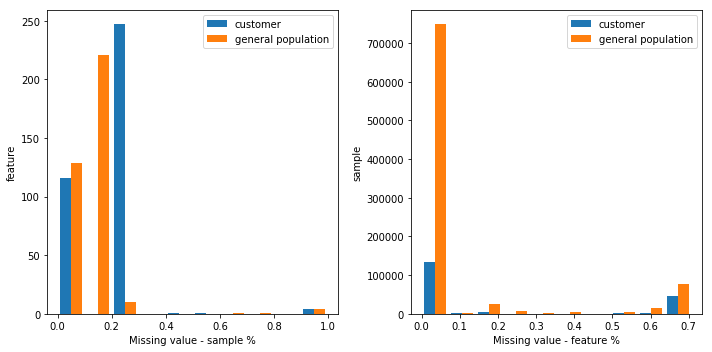

In [93]:
plt.figure(figsize = [10, 5])

plt.subplot(1, 2, 1)
plt.hist((customers_df.isnull().mean(), azdias_df.isnull().mean()), label=['customer', 'general population'])
plt.xlabel('Missing value - sample %')
plt.ylabel('feature')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist((customers_df.isnull().mean(axis=1), azdias_df.isnull().mean(axis=1)), label=['customer', 'general population'])
plt.xlabel('Missing value - feature %')
plt.ylabel('sample')
plt.legend()

plt.tight_layout()
plt.show()

### Data Preprocessing
Create a `clean_data` function for data cleaning.

#### What we want to do here ...
With previous knowledge of data exploration, in this section we would like to perfrom data cleaning. Our goal is to create a perform data cleaning, I will step by step go through below funcstions. Finally, we will combine this function in one single function `clean_data`.

* `unknown2nd`: Convert all unknown value to NA.
* `formatit`: Change undocumented value to NA. Try to match 'DIAS Attributes - Values 2017.xlsx' Value field.
* Analyze categorical and quantitative feature.
    - Category feature handling
        - Binary: Do-nothing
        - Nominal: Drop feature with more than 15 values
        - Ordinal: Drop feature with more than 15 values
        - Mixed: Convert to nominal or ordinal
    - Quantative feature handling
        - `log_transform` as below
        - `cap_outlier` as below
* `drop`: Drop unused features.
    - Will drop missing value > 70% feature
* `log_transform`: Normalize quantitative feature with log transfor.
* `cap_outlier`: Capping the outlier rows with Percentiles
* `cover`: Scan feature coverage with general population and customer.
* `fillna`: Fill every NA field a value.
    - Categorical feature: maximum occurred value, 
    - Quantitative feature: median
* `onehot`: Apply one-hot encoding aming nominal categorical features.
* `clean_data`: integrate above procedure to one function.

In [94]:
# dictionary to hold all type of documented features
annot_attr_azdias_values_dict = {
    'bin_cat': azdias_bin_cat_annot_attribute,  # documented binary category feature
    'nom_cat': azdias_nom_cat_annot_attribute,  # documented nominal category feature
    'ord_cat': azdias_ord_cat_annot_attribute,  # documented ordinal category feature
    'mix_cat': azdias_mix_cat_annot_attribute,  # documented mixed caztegory feature
    'num': azdias_num_annot_attribute,  # documented quantitative feature
    'unused': azdias_unused_annot_attribute  # documented unused feature
}

# dictionary to hold all type of undocumented features
not_annot_attr_azdias_values_dict = {
    'bin_cat': azdias_bin_cat_not_annot_attribute,  # unuhdocumented binary category feature
    'nom_cat': azdias_nom_cat_not_annot_attribute,  # undocumented nominal category feature
    'ord_cat': azdias_ord_cat_not_annot_attribute,  # undocumented ordinal category feature
    'mix_cat': azdias_mix_cat_not_annot_attribute,  # undocumented mixed caztegory feature
    'num': azdias_num_not_annot_attribute,  # undocumented quantitative feature
    'unused': azdias_unused_not_annot_attribute  # undocumented unused feature
}

# dictionary to hold different type of unknow value
unknown_annot_attribute_dict = {
    'unknown': customers_unknown_values_df,  # 'unknown' meaning feature
    'main_age_unknown': customers_main_age_unknown_values_df,  # 'unknown / no main age detectable' meaning feature
    'transaction_unknown': customers_transaction_unknown_values_df,  # 'no transactions known' meaning feature 
    'transactions_unknown': customers_transactions_unknown_values_df,  # 'no transaction known' meaning feature 
}

new_customers_df = customers_df.copy()
new_azdias_df = azdias_df.copy()

In [95]:
annot_attr_azdias_values = annot_attr_customers_values
assert annot_attr_azdias_values.size == annot_attr_azdias_values_dict['bin_cat'].size \
                                        + annot_attr_azdias_values_dict['nom_cat'].size \
                                        + annot_attr_azdias_values_dict['ord_cat'].size \
                                        + annot_attr_azdias_values_dict['mix_cat'].size \
                                        + annot_attr_azdias_values_dict['num'].size \
                                        + annot_attr_azdias_values_dict['unused'].size

In [96]:
not_annot_attr_azdias_values = np.setdiff1d(not_annot_attr_customers_values, only_attr_customers)
assert not_annot_attr_azdias_values.size == not_annot_attr_azdias_values_dict['bin_cat'].size \
                                            + not_annot_attr_azdias_values_dict['nom_cat'].size \
                                            + not_annot_attr_azdias_values_dict['ord_cat'].size \
                                            + not_annot_attr_azdias_values_dict['mix_cat'].size \
                                            + not_annot_attr_azdias_values_dict['num'].size \
                                            + not_annot_attr_azdias_values_dict['unused'].size

In [98]:
# draw progressbar
def update_progress(progress):
    '''
    INPUT:
    progress - %
    
    OUTPUT:
    
    
    Description: Display a progress bar (https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/)
    '''
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

__NOTE__: `update_progress` is the function used to draw progress bar. Which inspired by [How to display a progress bar in Jupyter Notebook](https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/).

In [211]:
def unknown2na(df, unknown_dict=unknown_annot_attribute_dict):
    '''
    INPUT:
    df - pandas dataframe
    unknown_dict - dictionary to hold all type of unknown string features
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Convert all unknown value to NA.
    '''
    cnter = 0
    n_iters = sum([unknown_dict[k].shape[0] for k in unknown_dict.keys()])
    n_iters += 1

    for k in unknown_dict:
        v_df = unknown_dict[k]
        attrs = v_df.Attribute

        for attr in attrs:
            v_unknown = v_df[v_df.Attribute == attr].Value.values[0]
            
            if isinstance(v_unknown, str):
                v_unknown = list(map(int, v_unknown.split(',')))
                df[attr] = df[attr].apply(lambda x: x if not x in v_unknown else np.nan)
            else:
                df[attr] = df[attr].apply(lambda x: x if not x == v_unknown else np.nan)
            
            # Update the progress bar
            cnter+=1 
            update_progress(cnter / n_iters)
    
    update_progress(1)
            
    return df

In [ ]:
# Convert all unknown value to NA.
new_azdias_df = unknown2na(new_azdias_df)

In [ ]:
# Convert all unknown value to NA.
new_customers_df = unknown2na(new_customers_df)

In [ ]:
if DEBUG:
    new_azdias_df.to_pickle('new_azdias_df_unknown2na.pickle')
    new_customers_df.to_pickle('new_customers_df_unknown2na.pickle')

In [ ]:
if DEBUG:
    new_customers_df = pd.read_pickle("new_customers_df_unknown2na.pickle")
    new_azdias_df = pd.read_pickle("new_azdias_df_unknown2na.pickle")

In [212]:
def formatit(df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict):
    '''
    INPUT:
    df - pandas dataframe
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Change undocumented value to NA. Try to match 'DIAS Attributes - Values 2017.xlsx' Value field.
    '''
    cnter = 0
    n_iters = len([v for k in annot_attr_azdias_values_dict.keys() for v in annot_attr_azdias_values_dict[k] if v in df])
    n_iters += len([v for k in not_annot_attr_azdias_values_dict.keys() for v in not_annot_attr_azdias_values_dict[k] if v in df])
    n_iters += 1

    for k in annot_dict.keys():
        for v in annot_dict[k]:
            if v == 'OST_WEST_KZ':

                # change 'O': 0, 'W': 1
                df[v] = df[v].replace({'O':0, 'W':1})
            elif v == 'CAMEO_DEU_2015':

                # change 'XX' to NA
                df[v] = df[v].replace('XX', np.nan)
            elif v == 'CAMEO_DEUG_2015':

                # change '1', '2', '3', '4', '5', '6', '7', '8', '9' to integer, and 'X' to NA
                df[v] = df[v].replace('X', np.nan)
                df[v] = df[df[v].notna()][v].apply(lambda x: (int(x)))
            elif v == 'KBA05_MODTEMP':

                # change 6 to NA
                df[v] = df[v].replace(6, np.nan)
            elif np.isin(v, ['LP_FAMILIE_FEIN',
                            'LP_FAMILIE_GROB',
                            'LP_LEBENSPHASE_FEIN',
                            'LP_LEBENSPHASE_GROB']):

                # change 0 to NA
                df[v] = df[v].replace(0, np.nan)

            elif v == 'ORTSGR_KLS9':

                # change 0 to NA
                df[v] = df[v].replace(0, np.nan)
            else:

                if v in df:
                    # All other attribute: convert to integer
                    df[v] = df[df[v].notna()][v].apply(lambda x: int(x))

            # Update the progress bar
            cnter+=1 
            update_progress(cnter / n_iters)
    
    for k in not_annot_dict.keys():
        for v in not_annot_dict[k]:
            if v == 'EINGEFUEGT_AM':

                # convert datetime string to year based categorical feature
                df[v] = df[df[v].notna()][v].apply(lambda x: pd.to_datetime(x).year)
            elif v == 'D19_LETZTER_KAUF_BRANCHE':

                # change feature string to column index
                df[v] = df[df[v].notna()][v].apply(lambda x: np.where(customers_df.columns == x)[0][0] if x != 'D19_UNBEKANNT' else 0)
            elif v == 'CAMEO_INTL_2015':

                # change '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35', '23', '12', '44', '41', '52', '31', '13', '34', '32', '33' to integer, and 'XX' to NA
                df[v] = df[df[v].notna()][v].apply(lambda x: int(x) if x != 'XX' else np.nan)
            else:

                if v in df:
                    # All other attribute: convert to integer
                    df[v] = df[df[v].notna()][v].apply(lambda x: int(x))

            # Update the progress bar
            cnter+=1 
            update_progress(cnter / n_iters)
    
    update_progress(1)
    
    return df

In [ ]:
# Change undocumented value to NA. Try to match 'DIAS Attributes - Values 2017.xlsx' Value field.
new_azdias_df = formatit(new_azdias_df)

In [ ]:
# Change undocumented value to NA. Try to match 'DIAS Attributes - Values 2017.xlsx' Value field.
new_customers_df = formatit(new_customers_df)

In [ ]:
if DEBUG:
    new_azdias_df.to_pickle('new_azdias_df_formatit.pickle')
    new_customers_df.to_pickle('new_customers_df_formatit.pickle')

In [99]:
if DEBUG:
    new_azdias_df = pd.read_pickle("new_azdias_df_formatit.pickle")
    new_customers_df = pd.read_pickle("new_customers_df_formatit.pickle")

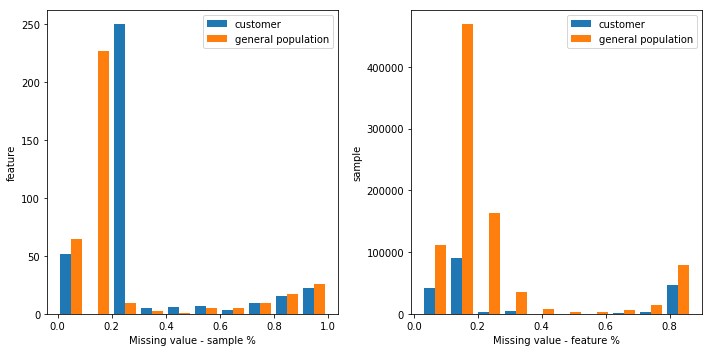

In [100]:
plt.figure(figsize = [10, 5])

plt.subplot(1, 2, 1)
plt.hist((new_customers_df.isnull().mean(), new_azdias_df.isnull().mean()), label=['customer', 'general population'])
plt.xlabel('Missing value - sample %')
plt.ylabel('feature')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist((new_customers_df.isnull().mean(axis=1), new_azdias_df.isnull().mean(axis=1)), label=['customer', 'general population'])
plt.xlabel('Missing value - feature %')
plt.ylabel('sample')
plt.legend()

plt.tight_layout()
plt.show()

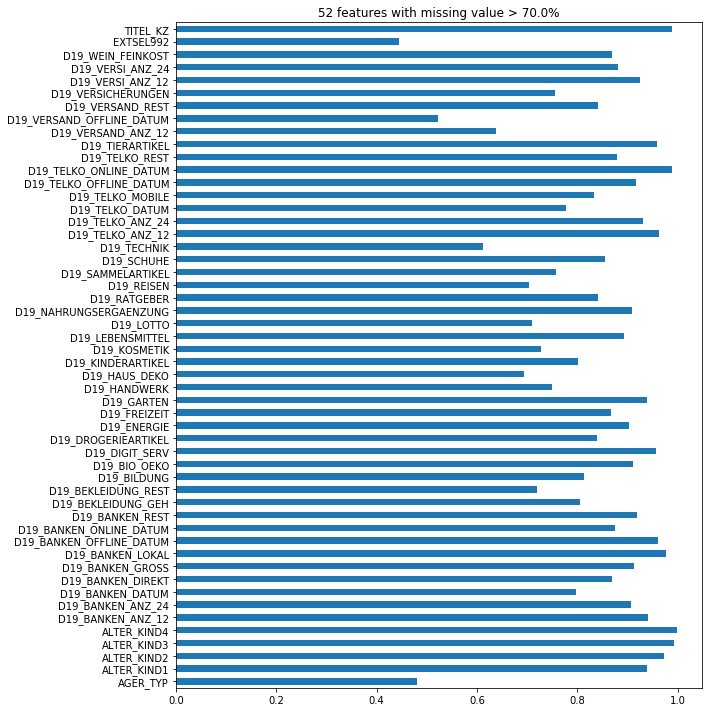

In [101]:
_ = np.setdiff1d(new_azdias_df.columns[new_azdias_df.isnull().mean() > FEATURE_DROP_RATIO], annot_attr_azdias_values_dict['unused'])
_ = np.union1d(_, np.setdiff1d(new_azdias_df.columns[new_azdias_df.isnull().mean() > FEATURE_DROP_RATIO], not_annot_attr_azdias_values_dict['unused']))

plt.figure(figsize = [10, 10])
new_customers_df[_].isnull().mean().plot.barh()
plt.title('{} features with missing value > {}%'.format(np.setdiff1d(_, 'LNR').size, FEATURE_DROP_RATIO*100))
plt.tight_layout()
plt.show()

#### Analyze categorical feature

Check all category feature unique value range

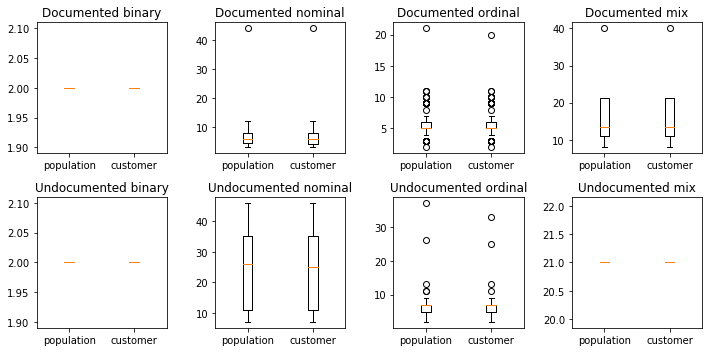

In [102]:
plt.figure(figsize = [10, 5])

plt.subplot(2,4,1)
plt.boxplot([new_azdias_df[annot_attr_azdias_values_dict['bin_cat']].nunique(), new_customers_df[annot_attr_azdias_values_dict['bin_cat']].nunique()], labels=['population', 'customer'])
plt.title('Documented binary')

plt.subplot(2,4,2)
plt.boxplot([new_azdias_df[annot_attr_azdias_values_dict['nom_cat']].nunique(), new_customers_df[annot_attr_azdias_values_dict['nom_cat']].nunique()], labels=['population', 'customer'])
plt.title('Documented nominal')

plt.subplot(2,4,3)
plt.boxplot([new_azdias_df[annot_attr_azdias_values_dict['ord_cat']].nunique(), new_customers_df[annot_attr_azdias_values_dict['ord_cat']].nunique()], labels=['population', 'customer'])
plt.title('Documented ordinal')

plt.subplot(2,4,4)
plt.boxplot([new_azdias_df[annot_attr_azdias_values_dict['mix_cat']].nunique(), new_customers_df[annot_attr_azdias_values_dict['mix_cat']].nunique()], labels=['population', 'customer'])
plt.title('Documented mix')

plt.subplot(2,4,5)
plt.boxplot([new_azdias_df[not_annot_attr_azdias_values_dict['bin_cat']].nunique(), new_customers_df[not_annot_attr_azdias_values_dict['bin_cat']].nunique()], labels=['population', 'customer'])
plt.title('Undocumented binary')

plt.subplot(2,4,6)
plt.boxplot([new_azdias_df[not_annot_attr_azdias_values_dict['nom_cat']].nunique(), new_customers_df[not_annot_attr_azdias_values_dict['nom_cat']].nunique()], labels=['population', 'customer'])
plt.title('Undocumented nominal')

plt.subplot(2,4,7)
plt.boxplot([new_azdias_df[not_annot_attr_azdias_values_dict['ord_cat']].nunique(), new_customers_df[not_annot_attr_azdias_values_dict['ord_cat']].nunique()], labels=['population', 'customer'])
plt.title('Undocumented ordinal')

plt.subplot(2,4,8)
plt.boxplot([new_azdias_df[not_annot_attr_azdias_values_dict['mix_cat']].nunique(), new_customers_df[not_annot_attr_azdias_values_dict['mix_cat']].nunique()], labels=['population', 'customer'])
plt.title('Undocumented mix')

plt.tight_layout()
plt.show()

After browse value range of different type features, we would like to drop feature outliers.
* **Nominal categorical feature have more than 15 values: drop**
* **Ordinal categorical feature have more than 15 values: drop**

Analyze `annot_attr_azdias_values_dict['nom_cat']`

In [103]:
# scan unique value
for v in annot_attr_azdias_values_dict['nom_cat']:
    nunique =  new_azdias_df[v].nunique()
    if nunique > 15:
        print('{} have {} unique values (>15)'.format(v, new_azdias_df[v].nunique()))

CAMEO_DEU_2015 have 44 unique values (>15)


__NOTE__: drop CAMEO_DEU_2015 (44 unique value, too large)

Analyze `annot_attr_azdias_values_dict['ord_cat']`

In [104]:
# scan unique value
for v in annot_attr_azdias_values_dict['ord_cat']:
    nunique =  new_azdias_df[v].nunique()
    if nunique > 15:
        print('{} have {} unique values (>15)'.format(v, new_azdias_df[v].nunique()))

ALTER_HH have 21 unique values (>15)


__NOTE__: drop ALTER_HH (21 unique value, too large)

Analyze `annot_attr_azdias_values_dict['mix_cat']`

LP_LEBENSPHASE_FEIN: **contains information about life stage and fine scale. I will create two new ordinals features, one for life_stage and other for fine_scale**

In [105]:
age_dict = {'younger_age': 0, 'middle_age': 1, 'advanced_age': 2, 'retirement_age': 3}
life_stage = {1: age_dict['younger_age'], 2: age_dict['middle_age'], 3: age_dict['younger_age'],
              4: age_dict['middle_age'], 5: age_dict['advanced_age'], 6: age_dict['retirement_age'],
              7: age_dict['advanced_age'], 8: age_dict['retirement_age'], 9: age_dict['middle_age'],
              10: age_dict['middle_age'], 11: age_dict['advanced_age'], 12: age_dict['retirement_age'],
              13: age_dict['advanced_age'], 14: age_dict['younger_age'], 15: age_dict['advanced_age'],
              16: age_dict['advanced_age'], 17: age_dict['middle_age'], 18: age_dict['younger_age'],
              19: age_dict['advanced_age'], 20: age_dict['advanced_age'], 21: age_dict['middle_age'],
              22: age_dict['middle_age'], 23: age_dict['middle_age'], 24: age_dict['middle_age'],
              25: age_dict['middle_age'], 26: age_dict['middle_age'], 27: age_dict['middle_age'],
              28: age_dict['middle_age'], 29: age_dict['younger_age'], 30: age_dict['younger_age'],
              31: age_dict['advanced_age'], 32: age_dict['advanced_age'], 33: age_dict['younger_age'],
              34: age_dict['younger_age'], 35: age_dict['younger_age'], 36: age_dict['advanced_age'],
              37: age_dict['advanced_age'], 38: age_dict['retirement_age'], 39: age_dict['middle_age'],
              40: age_dict['retirement_age']}

fine_dict = {'low': 0, 'average': 1, 'wealthy': 2, 'top': 3}                                                                                      
fine_scale = {1: fine_dict['low'], 2: fine_dict['low'], 3: fine_dict['average'], 4: fine_dict['average'], 5: fine_dict['low'], 6: fine_dict['low'],
              7: fine_dict['average'], 8: fine_dict['average'], 9: fine_dict['average'], 10: fine_dict['wealthy'], 11: fine_dict['average'],
              12: fine_dict['average'], 13: fine_dict['top'], 14: fine_dict['average'], 15: fine_dict['low'], 16: fine_dict['average'],
              17: fine_dict['average'], 18: fine_dict['wealthy'], 19: fine_dict['wealthy'], 20: fine_dict['top'], 21: fine_dict['low'],
              22: fine_dict['average'], 23: fine_dict['wealthy'], 24: fine_dict['low'], 25: fine_dict['average'], 26: fine_dict['average'],
              27: fine_dict['average'], 28: fine_dict['top'], 29: fine_dict['low'], 30: fine_dict['average'], 31: fine_dict['low'],
              32: fine_dict['average'], 33: fine_dict['average'], 34: fine_dict['average'], 35: fine_dict['top'], 36: fine_dict['average'],
              37: fine_dict['average'], 38: fine_dict['average'], 39: fine_dict['top'], 40: fine_dict['top']}

# create LP_life_stage and LP_fine_scale column
new_azdias_df['LP_life_stage'] = new_azdias_df['LP_LEBENSPHASE_FEIN'].map(life_stage)
new_azdias_df['LP_fine_scale'] = new_azdias_df['LP_LEBENSPHASE_FEIN'].map(fine_scale)
new_customers_df['LP_life_stage'] = new_customers_df['LP_LEBENSPHASE_FEIN'].map(life_stage)
new_customers_df['LP_fine_scale'] = new_customers_df['LP_LEBENSPHASE_FEIN'].map(fine_scale)

LP_LEBENSPHASE_GROB **contains the same information as LP_LEBENSPHASE_FEIN. Therefore I will drop it.**

PRAEGENDE_JUGENDJAHRE: **combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I will create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.**

In [106]:
# Map decade
dec_dic = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
           8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90,
           15: 90, np.nan: np.nan, -1: np.nan, 0: np.nan}

# Map mouvement
mov_dic = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0,
           9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1,
           np.nan: np.nan, -1: np.nan, 0: np.nan}

# create PRAEGENDE_JUGENDJAHRE_dec and PRAEGENDE_JUGENDJAHRE_mov column
new_azdias_df['PRAEGENDE_JUGENDJAHRE_dec'] = new_azdias_df['PRAEGENDE_JUGENDJAHRE'].map(dec_dic)
new_azdias_df['PRAEGENDE_JUGENDJAHRE_mov'] = new_azdias_df['PRAEGENDE_JUGENDJAHRE'].map(mov_dic)
new_customers_df['PRAEGENDE_JUGENDJAHRE_dec'] = new_customers_df['PRAEGENDE_JUGENDJAHRE'].map(dec_dic)
new_customers_df['PRAEGENDE_JUGENDJAHRE_mov'] = new_customers_df['PRAEGENDE_JUGENDJAHRE'].map(mov_dic)

WOHNLAGE: **We create two new features NEIGHBORHOOD_QUALITY (Ordinal, vaulues from 1 to 5) and RURAL (Binary, 0= non-rural, 1=rural)**

In [107]:
neighbor_dict = {}
rural_dict = {0: 0, 1:0, 2:0, 3:0, 4:0, 5:0, 7:1, 8:1}

# create WOHNLAGE_rural and WOHNLAGE_neighborhood_quality column
new_azdias_df['WOHNLAGE_rural'] = new_azdias_df['WOHNLAGE'].map(rural_dict)
new_azdias_df['WOHNLAGE_neighborhood_quality'] = new_azdias_df[(new_azdias_df['WOHNLAGE'] >= 0) & (new_azdias_df['WOHNLAGE'] < 7)]['WOHNLAGE']

In [108]:
new_customers_df['WOHNLAGE_rural'] = new_customers_df['WOHNLAGE'].map(rural_dict)
new_customers_df['WOHNLAGE_neighborhood_quality'] = new_customers_df[(new_customers_df['WOHNLAGE'] >= 0) & (new_customers_df['WOHNLAGE'] < 7)]['WOHNLAGE']

Analyze `not_annot_attr_azdias_values_dict['nom_cat']`

In [109]:
# scan unique value
for v in not_annot_attr_azdias_values_dict['nom_cat']:
    nunique =  new_azdias_df[v].nunique()
    if nunique > 15:
        print('{} have {} unique values (>15)'.format(v, new_azdias_df[v].nunique()))

D19_LETZTER_KAUF_BRANCHE have 35 unique values (>15)
EINGEFUEGT_AM have 26 unique values (>15)
VERDICHTUNGSRAUM have 46 unique values (>15)


__NOTE__: drop D19_LETZTER_KAUF_BRANCHE (35 unique value, too large) ,drop EINGEFUEGT_AM (26 unique value, too large), drop VERDICHTUNGSRAUM (46 unique value, too large)

Analyze `not_annot_attr_azdias_values_dict['ord_cat']`

In [110]:
# scan unique value
for v in not_annot_attr_azdias_values_dict['ord_cat']:
    nunique =  new_azdias_df[v].nunique()
    if nunique > 15:
        print('{} have {} unique values (>15)'.format(v, new_azdias_df[v].nunique()))

ALTERSKATEGORIE_FEIN have 26 unique values (>15)
EINGEZOGENAM_HH_JAHR have 37 unique values (>15)


__NOTE__: drop ALTERSKATEGORIE_FEIN (26 unique value, too large), drop EINGEZOGENAM_HH_JAHR (37 unique value, too large)

Analyze `not_annot_attr_azdias_values_dict['mix_cat']`

In [111]:
# create CAMEO_INTL_2015_wealth and CAMEO_INTL_2015_family column
new_azdias_df['CAMEO_INTL_2015_wealth'] = new_azdias_df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
new_azdias_df['CAMEO_INTL_2015_family'] = new_azdias_df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)

# create CAMEO_INTL_2015_wealth and CAMEO_INTL_2015_family column
new_customers_df['CAMEO_INTL_2015_wealth'] = new_customers_df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
new_customers_df['CAMEO_INTL_2015_family'] = new_customers_df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan) 

#### Analyze quantitative feature

In [112]:
num_cols = np.union1d(annot_attr_azdias_values_dict['num'], not_annot_attr_azdias_values_dict['num'])
num_cols

array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'GEBURTSJAHR',
       'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'], dtype=object)

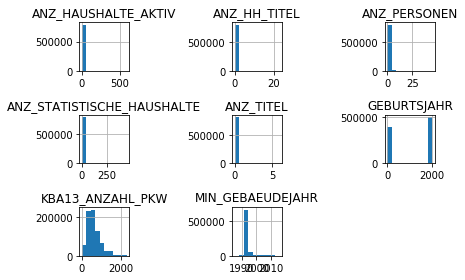

In [113]:
for i in range(num_cols.size):
    ax = plt.subplot(3, 3, i+1)
    new_azdias_df[num_cols[i]].hist(ax=ax)
    plt.title(num_cols[i])

plt.tight_layout()
plt.show()

__NOTE__: 
1. ANZ_HAUSHALTE_AKTIV, ANZ_HH_TITEL, ANZ_PERSONEN, ANZ_STATISTISCHE_HAUSHALTE, ANZ_TITEL: log transform

Analyze GEBURTSJAHR (year of birth)

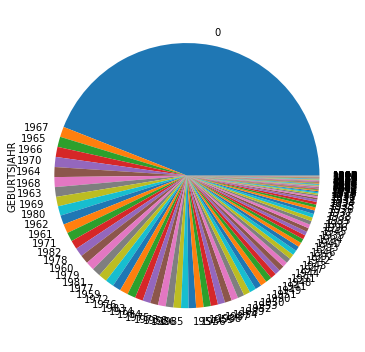

In [114]:
plt.figure(figsize = [10, 5])
azdias_df['GEBURTSJAHR'].value_counts().plot.pie()
plt.tight_layout()
plt.show()

__NOTE__: GEBURTSJAHR: drop (almost half are year of birth = 0, abnormal)

In [115]:
col_outlier = np.array(['ALTERSKATEGORIE_FEIN', 'ALTER_HH',
       'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE',
       'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'VERDICHTUNGSRAUM', 'WOHNLAGE', 'ANZ_STATISTISCHE_HAUSHALTE', 'LP_STATUS_GROB',
       'KBA13_BAUMAX'])

In [116]:
# calculate all type fo documented feature
annot_attr_azdias_values = np.union1d(annot_attr_azdias_values, ['LP_life_stage', 
                                                                 'LP_fine_scale', 
                                                                 'PRAEGENDE_JUGENDJAHRE_dec', 
                                                                 'PRAEGENDE_JUGENDJAHRE_mov',
                                                                 'WOHNLAGE_rural',
                                                                 'WOHNLAGE_neighborhood_quality'])

annot_attr_azdias_values_dict['unused'] = np.union1d(annot_attr_azdias_values_dict['unused'], annot_attr_azdias_values_dict['mix_cat'])
annot_attr_azdias_values_dict['unused'] = np.union1d(annot_attr_azdias_values_dict['unused'], ['CAMEO_DEU_2015', 'ALTER_HH', 'GEBURTSJAHR', 'LP_STATUS_GROB'])
annot_attr_azdias_values_dict['mix_cat'] = np.array([])
annot_attr_azdias_values_dict['bin_cat'] = np.union1d(annot_attr_azdias_values_dict['bin_cat'], 'WOHNLAGE_rural')
annot_attr_azdias_values_dict['nom_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['nom_cat'], 'CAMEO_DEU_2015')
annot_attr_azdias_values_dict['ord_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['ord_cat'], ['ALTER_HH', 'LP_STATUS_GROB'])
annot_attr_azdias_values_dict['ord_cat'] = np.union1d(annot_attr_azdias_values_dict['ord_cat'], ['WOHNLAGE_neighborhood_quality'])
annot_attr_azdias_values_dict['nom_cat'] = np.union1d(annot_attr_azdias_values_dict['nom_cat'], ['LP_life_stage', \
                                                                                                 'LP_fine_scale', \
                                                                                                 'PRAEGENDE_JUGENDJAHRE_dec', \
                                                                                                 'PRAEGENDE_JUGENDJAHRE_mov'])
annot_attr_azdias_values_dict['num'] = np.setdiff1d(annot_attr_azdias_values_dict['num'], ['GEBURTSJAHR'])

# calculate all type fo undocumented feature
not_annot_attr_azdias_values = np.union1d(not_annot_attr_azdias_values, ['CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_family'])

not_annot_attr_azdias_values_dict['unused'] = np.union1d(not_annot_attr_azdias_values_dict['unused'], not_annot_attr_azdias_values_dict['mix_cat'])
not_annot_attr_azdias_values_dict['unused'] = np.union1d(not_annot_attr_azdias_values_dict['unused'], ['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'VERDICHTUNGSRAUM', 'ANZ_STATISTISCHE_HAUSHALTE'])
not_annot_attr_azdias_values_dict['unused'] = np.union1d(not_annot_attr_azdias_values_dict['unused'], ['ALTERSKATEGORIE_FEIN', 'EINGEZOGENAM_HH_JAHR', 'KBA13_BAUMAX'])                                                 
not_annot_attr_azdias_values_dict['mix_cat'] = np.array([])
not_annot_attr_azdias_values_dict['nom_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['nom_cat'], ['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'VERDICHTUNGSRAUM'])
not_annot_attr_azdias_values_dict['ord_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['ord_cat'], ['ALTERSKATEGORIE_FEIN', 'EINGEZOGENAM_HH_JAHR', 'KBA13_BAUMAX'])
not_annot_attr_azdias_values_dict['nom_cat'] = np.union1d(not_annot_attr_azdias_values_dict['nom_cat'], ['CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_family'])
not_annot_attr_azdias_values_dict['num'] = np.setdiff1d(not_annot_attr_azdias_values_dict['num'], ['ANZ_STATISTISCHE_HAUSHALTE'])

In [117]:
# calculate all type fo documented feature
annot_attr_azdias_values_dict['unused'] = np.union1d(annot_attr_azdias_values_dict['unused'], \
                                np.intersect1d(np.concatenate(list(annot_attr_azdias_values_dict.values())), new_azdias_df.columns[new_azdias_df.isnull().mean() > FEATURE_DROP_RATIO]))
annot_attr_azdias_values_dict['bin_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['bin_cat'], annot_attr_azdias_values_dict['unused'])
annot_attr_azdias_values_dict['nom_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['nom_cat'], annot_attr_azdias_values_dict['unused'])
annot_attr_azdias_values_dict['ord_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['ord_cat'], annot_attr_azdias_values_dict['unused'])
annot_attr_azdias_values_dict['mix_cat'] = np.setdiff1d(annot_attr_azdias_values_dict['mix_cat'], annot_attr_azdias_values_dict['unused'])
annot_attr_azdias_values_dict['num'] = np.setdiff1d(annot_attr_azdias_values_dict['num'], annot_attr_azdias_values_dict['unused'])

/Users/fc/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:518: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [118]:
# calculate all type fo undocumented feature
not_annot_attr_azdias_values_dict['unused'] = np.union1d(not_annot_attr_azdias_values_dict['unused'], \
                                np.intersect1d(np.concatenate(list(not_annot_attr_azdias_values_dict.values())), new_azdias_df.columns[new_azdias_df.isnull().mean() > FEATURE_DROP_RATIO]))
not_annot_attr_azdias_values_dict['bin_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['bin_cat'], not_annot_attr_azdias_values_dict['unused'])
not_annot_attr_azdias_values_dict['nom_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['nom_cat'], not_annot_attr_azdias_values_dict['unused'])
not_annot_attr_azdias_values_dict['ord_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['ord_cat'], not_annot_attr_azdias_values_dict['unused'])
not_annot_attr_azdias_values_dict['mix_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['mix_cat'], not_annot_attr_azdias_values_dict['unused'])
not_annot_attr_azdias_values_dict['num'] = np.setdiff1d(not_annot_attr_azdias_values_dict['num'], not_annot_attr_azdias_values_dict['unused'])

/Users/fc/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:518: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [119]:
assert annot_attr_azdias_values.size == annot_attr_azdias_values_dict['bin_cat'].size \
                                        + annot_attr_azdias_values_dict['nom_cat'].size \
                                        + annot_attr_azdias_values_dict['ord_cat'].size \
                                        + annot_attr_azdias_values_dict['mix_cat'].size \
                                        + annot_attr_azdias_values_dict['num'].size \
                                        + annot_attr_azdias_values_dict['unused'].size

In [120]:
assert not_annot_attr_azdias_values.size == not_annot_attr_azdias_values_dict['bin_cat'].size \
                                            + not_annot_attr_azdias_values_dict['nom_cat'].size \
                                            + not_annot_attr_azdias_values_dict['ord_cat'].size \
                                            + not_annot_attr_azdias_values_dict['mix_cat'].size \
                                            + not_annot_attr_azdias_values_dict['num'].size \
                                            + not_annot_attr_azdias_values_dict['unused'].size

Move LNR as index to preserve information for segmentation and modeling usage

In [121]:
new_azdias_df.set_index('LNR', inplace=True)
new_customers_df.set_index('LNR', inplace=True)

In [122]:
def drop(df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict):
    '''
    INPUT:
    df - pandas dataframe
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Drop unused features.
    '''  
    ## drop ferature
    cols = [v for k in annot_dict.keys() for v in annot_dict[k]]
    cols += [v for k in not_annot_dict.keys() for v in not_annot_dict[k]]
    cols = np.setdiff1d(cols, annot_dict['unused'])
    cols = np.setdiff1d(cols, not_annot_dict['unused'])
    df = df[cols]
    
    return df

In [123]:
# Drop unused features
new_azdias_df = drop(new_azdias_df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict)
new_customers_df = drop(new_customers_df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict)

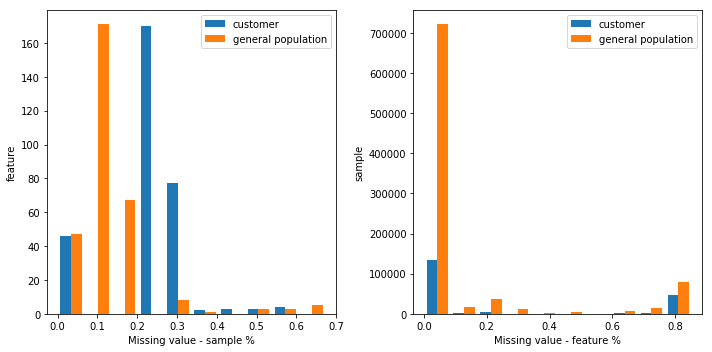

In [124]:
plt.figure(figsize = [10, 5])

plt.subplot(1, 2, 1)
plt.hist((new_customers_df.isnull().mean(), new_azdias_df.isnull().mean()), label=['customer', 'general population'])
plt.xlabel('Missing value - sample %')
plt.ylabel('feature')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist((new_customers_df.isnull().mean(axis=1), new_azdias_df.isnull().mean(axis=1)), label=['customer', 'general population'])
plt.xlabel('Missing value - feature %')
plt.ylabel('sample')
plt.legend()

plt.tight_layout()
plt.show()

In [125]:
if DEBUG:
    new_azdias_df.to_pickle('new_azdias_df_drop.pickle')
    new_customers_df.to_pickle('new_customers_df_drop.pickle')

In [140]:
if DEBUG:
    new_azdias_df = pd.read_pickle("new_azdias_df_drop.pickle")
    new_customers_df = pd.read_pickle("new_customers_df_drop.pickle")

In [141]:
def log_transform(df, cols):
    '''
    INPUT:
    df - pandas dataframe
    cols - log transfer comlumns.
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Normalize quantitative feature with log transfor.
    '''
    for col in cols:
        if col == 'MIN_GEBAEUDEJAHR':
            df[col] = np.log1p(df[col] - df[col].min())
        else:
            df[col] = np.log1p(df[col])
    
    return df

In [142]:
log_cols = np.array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL'])
log_cols

array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL'],
      dtype='<U19')

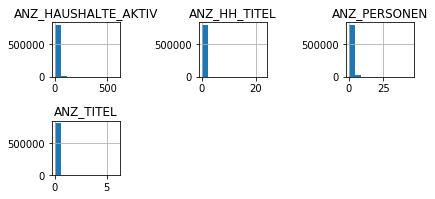

In [143]:
for i in range(log_cols.size):
    ax = plt.subplot(3, 3, i+1)
    new_azdias_df[log_cols[i]].hist(ax=ax)
    plt.title(log_cols[i])

plt.tight_layout()
plt.show()

In [144]:
# log transfer comlumns
new_azdias_df = log_transform(new_azdias_df, log_cols)

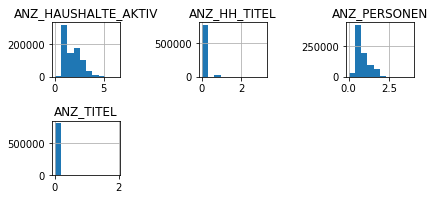

In [145]:
for i in range(log_cols.size):
    ax = plt.subplot(3, 3, i+1)
    new_azdias_df[log_cols[i]].hist(ax=ax)
    plt.title(log_cols[i])

plt.tight_layout()
plt.show()

In [146]:
# log transfer comlumns
new_customers_df = log_transform(new_customers_df, log_cols)

In [151]:
if DEBUG:
    new_azdias_df.to_pickle('new_azdias_df_log.pickle')
    new_customers_df.to_pickle('new_customers_df_log.pickle')

In [152]:
if DEBUG:
    new_azdias_df = pd.read_pickle("new_azdias_df_log.pickle")
    new_customers_df = pd.read_pickle("new_customers_df_log.pickle")

In [153]:
def cap_outlier(df, cols):
    '''
    INPUT:
    df - pandas dataframe
    cols - find outlier columns
    ratio - ratio feature are all outlier will be considered as true outlier
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Capping the outlier rows with Percentiles.
    '''
    outliers  = pd.Series([])
    sol = []
    
    i = 0

    # For each feature find the data points with extreme high or low values
    for col in cols:
        #Capping the outlier rows with Percentiles
        upper_lim = df[col].quantile(.95)
        lower_lim = df[col].quantile(.05)
        
        df.loc[(df[col] > upper_lim),col] = upper_lim
        df.loc[(df[col] < lower_lim),col] = lower_lim

    
    return df

In [154]:
num_cols = np.union1d(annot_attr_azdias_values_dict['num'], not_annot_attr_azdias_values_dict['num'])
num_cols

array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR'], dtype=object)

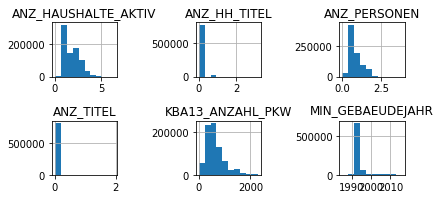

In [155]:
for i, col in enumerate(num_cols):
    ax = plt.subplot(3, 3, i+1)
    new_azdias_df[col].hist(ax=ax)
    plt.title(col)

plt.tight_layout()
plt.show()

In [156]:
# Capping the outlier rows with Percentiles
new_azdias_df = cap_outlier(new_azdias_df, num_cols)

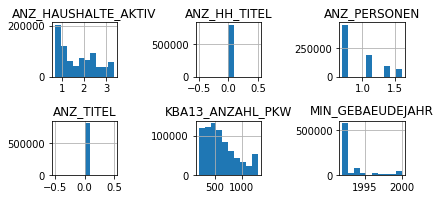

In [157]:
for i, col in enumerate(num_cols):
    ax = plt.subplot(3, 3, i+1)
    new_azdias_df[col].hist(ax=ax)
    plt.title(col)

plt.tight_layout()
plt.show()

In [158]:
# Capping the outlier rows with Percentiles
new_customers_df = cap_outlier(new_customers_df, num_cols)

In [159]:
if DEBUG:
    new_azdias_df.to_pickle('new_azdias_df_outlier.pickle')
    new_customers_df.to_pickle('new_customers_df_outlier.pickle')

In [160]:
if DEBUG:
    new_azdias_df = pd.read_pickle("new_azdias_df_outlier.pickle")
    new_customers_df = pd.read_pickle("new_customers_df_outlier.pickle")

In [161]:
def cover(population_df, sample_df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict):
    '''
    INPUT:
    population_df - pandas dataframe for general population
    sample_df - pandas dataframe for sample
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    
    Description: Scan feature overlay with population and sample.
    '''
    for col in population_df.columns:
        if col in sample_df:
            if not np.isin(col, np.union1d(annot_dict['num'], not_annot_dict['num'])):       
                population_v = population_df[col].dropna().unique()
                sample_v = sample_df[col].dropna().unique()

                # value only in population
                diff_population_v = np.setdiff1d(population_v, sample_v)
                # value only in sample
                diff_sample_v = np.setdiff1d(sample_v, population_v)

                if diff_sample_v.size > 0:
                    print('{} have value only in sample : {} -> drop'.format(col, diff_sample_v))
                    sample_df.loc[sample_df[col].isin(diff_sample_v), col] = np.nan
                    
                if col in annot_dict['nom_cat'].tolist()+not_annot_dict['nom_cat'].tolist():
                    if diff_population_v.size > 0:
                        print('nom_cat type {} have value only in population : {} -> drop'.format(col, diff_population_v))
                        population_df.loc[population_df[col].isin(diff_population_v), col] = np.nan

            else:
                # max value of population
                max_population_v = population_df[col].dropna().max()
                # min value of population
                min_population_v = population_df[col].dropna().min()

                # max value of sample
                max_sample_v = sample_df[col].dropna().max()
                # min value of sample
                min_sample_v = sample_df[col].dropna().min()

                if min_population_v > min_sample_v:
                    print('{} in general population have min value: {} larger than sample: {} -> drop'.format(col, min_population_v, min_sample_v))
                    sample_df.loc[sample_df[col] < min_population_v, col] = np.nan
                if max_population_v < max_sample_v:
                    print('{} in general population have max value: {} smaller than sample: {} -> drop'.format(col, max_population_v, max_sample_v))
                    sample_df.loc[sample_df[col] > max_population_v, col] = np.nan

In [162]:
# Scan feature overlay with population and sample
cover(new_azdias_df, new_customers_df)

ANZ_PERSONEN in general population have max value: 1.6094379124341003 smaller than sample: 1.791759469228055 -> drop
nom_cat type GEBAEUDETYP have value only in population : [5.] -> drop
KBA13_ANZAHL_PKW in general population have max value: 1300.0 smaller than sample: 1400.0 -> drop


In [163]:
def fillna(df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict):
    '''
    INPUT:
    df - pandas dataframe
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Fill every NA field a value. Categorical feature: maximum occurred value, Quantitative feature: median
    '''
    cat_cols = annot_dict['bin_cat'].tolist() + not_annot_dict['bin_cat'].tolist() \
                + annot_dict['nom_cat'].tolist() + not_annot_dict['nom_cat'].tolist() \
                + annot_dict['ord_cat'].tolist() + not_annot_dict['ord_cat'].tolist()
    for col in df.columns:
        if col in cat_cols:
            # cztegorical feature
            # Max fill function for categorical
            df[col] = df[col].fillna(df[col].value_counts().idxmax())
            
        else:
            # quantitaive feature
            # Filling missing values with medians of the columns
            df[col] = df[col].fillna(df[col].median())
    return df

In [164]:
# Fill every NA field a value. Categorical feature: maximum occurred value,, Quantitative feature: median
new_azdias_df = fillna(new_azdias_df)

# for clean_data cover() usage
template_new_azdias_df = new_azdias_df.copy()

In [165]:
# Fill every NA field a value. Categorical feature: maximum occurred value,, Quantitative feature: median
new_customers_df = fillna(new_customers_df)

In [166]:
assert new_azdias_df.isnull().mean().sum() == 0

In [167]:
def onehot(df, cols):
    '''
    INPUT:
    df - pandas dataframe
    cols - columns to perform one-hot encoding
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Apply one-hot encoding aming nominal categorical features.
    '''
    for col in cols:
        dummy_df = pd.get_dummies(df[col], prefix=col, prefix_sep='_')
        
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(col, axis=1), dummy_df], axis=1)
    
    return df

In [168]:
onehot_cols = np.union1d(annot_attr_azdias_values_dict['nom_cat'], not_annot_attr_azdias_values_dict['nom_cat'])
onehot_cols

array(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015_family',
       'CAMEO_INTL_2015_wealth', 'CJT_GESAMTTYP', 'D19_KONSUMTYP',
       'FINANZTYP', 'GEBAEUDETYP', 'GEMEINDETYP', 'GFK_URLAUBERTYP',
       'HEALTH_TYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_fine_scale', 'LP_life_stage', 'NATIONALITAET_KZ',
       'PRAEGENDE_JUGENDJAHRE_dec', 'PRAEGENDE_JUGENDJAHRE_mov',
       'SHOPPER_TYP', 'VK_DHT4A', 'ZABEOTYP'], dtype=object)

In [169]:
new_azdias_df.shape

(891221, 305)

In [170]:
# Apply one-hot encoding aming nominal categorical features
new_azdias_df = onehot(new_azdias_df, onehot_cols)

In [171]:
new_azdias_df.shape

(891221, 407)

In [172]:
# Apply one-hot encoding aming nominal categorical features
new_customers_df = onehot(new_customers_df, onehot_cols)

In [173]:
assert new_azdias_df.shape[1] == new_customers_df.shape[1]

In [174]:
if DEBUG:
    new_azdias_df.to_pickle('new_azdias_df_onehot.pickle')
    new_customers_df.to_pickle('new_customers_df_onehot.pickle')

### Put it all together

Create a `clean_data` function to apply all steps of Data Preprocessing.

In [175]:
def mix_cat(df):
    '''
    INPUT:
    df - pandas dataframe
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Create mixed categorical feature to binary, nominal or ordinal categorical feature.
    '''
    # map LP_LEBENSPHASE_FEIN to LP_life_stage and LP_fine_scale
    age_dict = {'younger_age': 0, 'middle_age': 1, 'advanced_age': 2, 'retirement_age': 3}
    life_stage = {1: age_dict['younger_age'], 2: age_dict['middle_age'], 3: age_dict['younger_age'],
                  4: age_dict['middle_age'], 5: age_dict['advanced_age'], 6: age_dict['retirement_age'],
                  7: age_dict['advanced_age'], 8: age_dict['retirement_age'], 9: age_dict['middle_age'],
                  10: age_dict['middle_age'], 11: age_dict['advanced_age'], 12: age_dict['retirement_age'],
                  13: age_dict['advanced_age'], 14: age_dict['younger_age'], 15: age_dict['advanced_age'],
                  16: age_dict['advanced_age'], 17: age_dict['middle_age'], 18: age_dict['younger_age'],
                  19: age_dict['advanced_age'], 20: age_dict['advanced_age'], 21: age_dict['middle_age'],
                  22: age_dict['middle_age'], 23: age_dict['middle_age'], 24: age_dict['middle_age'],
                  25: age_dict['middle_age'], 26: age_dict['middle_age'], 27: age_dict['middle_age'],
                  28: age_dict['middle_age'], 29: age_dict['younger_age'], 30: age_dict['younger_age'],
                  31: age_dict['advanced_age'], 32: age_dict['advanced_age'], 33: age_dict['younger_age'],
                  34: age_dict['younger_age'], 35: age_dict['younger_age'], 36: age_dict['advanced_age'],
                  37: age_dict['advanced_age'], 38: age_dict['retirement_age'], 39: age_dict['middle_age'],
                  40: age_dict['retirement_age']}
    fine_dict = {'low': 0, 'average': 1, 'wealthy': 2, 'top': 3}                                                                                      
    fine_scale = {1: fine_dict['low'], 2: fine_dict['low'], 3: fine_dict['average'], 4: fine_dict['average'], 5: fine_dict['low'], 6: fine_dict['low'],
                  7: fine_dict['average'], 8: fine_dict['average'], 9: fine_dict['average'], 10: fine_dict['wealthy'], 11: fine_dict['average'],
                  12: fine_dict['average'], 13: fine_dict['top'], 14: fine_dict['average'], 15: fine_dict['low'], 16: fine_dict['average'],
                  17: fine_dict['average'], 18: fine_dict['wealthy'], 19: fine_dict['wealthy'], 20: fine_dict['top'], 21: fine_dict['low'],
                  22: fine_dict['average'], 23: fine_dict['wealthy'], 24: fine_dict['low'], 25: fine_dict['average'], 26: fine_dict['average'],
                  27: fine_dict['average'], 28: fine_dict['top'], 29: fine_dict['low'], 30: fine_dict['average'], 31: fine_dict['low'],
                  32: fine_dict['average'], 33: fine_dict['average'], 34: fine_dict['average'], 35: fine_dict['top'], 36: fine_dict['average'],
                  37: fine_dict['average'], 38: fine_dict['average'], 39: fine_dict['top'], 40: fine_dict['top']}
    # create LP_life_stage and LP_fine_scale column
    df['LP_life_stage'] = df['LP_LEBENSPHASE_FEIN'].map(life_stage)
    df['LP_fine_scale'] = df['LP_LEBENSPHASE_FEIN'].map(fine_scale)
    
    # map PRAEGENDE_JUGENDJAHRE to PRAEGENDE_JUGENDJAHRE_dec and PRAEGENDE_JUGENDJAHRE_mov
    # Map decade
    dec_dic = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
               8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90,
               15: 90, np.nan: np.nan, -1: np.nan, 0: np.nan}
    # Map mouvement
    mov_dic = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0,
               9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1,
               np.nan: np.nan, -1: np.nan, 0: np.nan}
    # create PRAEGENDE_JUGENDJAHRE_dec and PRAEGENDE_JUGENDJAHRE_mov column
    df['PRAEGENDE_JUGENDJAHRE_dec'] = df['PRAEGENDE_JUGENDJAHRE'].map(dec_dic)
    df['PRAEGENDE_JUGENDJAHRE_mov'] = df['PRAEGENDE_JUGENDJAHRE'].map(mov_dic)
    
    # map WOHNLAGE
    rural_dict = {1:0, 2:0, 3:0, 4:0, 5:0, 7:1, 8:1}
    # create WOHNLAGE_rural and WOHNLAGE_neighborhood_quality column
    df['WOHNLAGE_rural'] = df['WOHNLAGE'].map(rural_dict)
    df['WOHNLAGE_neighborhood_quality'] = df[(df['WOHNLAGE'] >= 0) & (df['WOHNLAGE'] < 7)]['WOHNLAGE']
    
    # map CAMEO_INTL_2015 to CAMEO_INTL_2015_wealth and CAMEO_INTL_2015_family
    # create CAMEO_INTL_2015_wealth and CAMEO_INTL_2015_family column
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
    df['CAMEO_INTL_2015_family'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)
    
    return df

In [176]:
def clean_data(df):
    '''
    INPUT:
    df - pandas dataframe
    
    OUTPUT:
    df - pandas dataframe
    
    Description: data preprocessing for dataframe.
    '''
    if 'RESPONSE' in df:
        not_annot_attr_azdias_values_dict['bin_cat'] = np.union1d(not_annot_attr_azdias_values_dict['bin_cat'], ['RESPONSE'])
    else:
        not_annot_attr_azdias_values_dict['bin_cat'] = np.setdiff1d(not_annot_attr_azdias_values_dict['bin_cat'], ['RESPONSE'])
    
    # Convert all unknown value to NA.
    print('unknown2na...')
    df = unknown2na(df)
    
    # Change undocumented value to NA. Try to match 'DIAS Attributes - Values 2017.xlsx' Value field.
    print('formatit...')
    df = formatit(df)
    
    # Create nom_cat column from mix_cat column.
    clear_output(wait = False)
    print('mix_cat...')
    df = mix_cat(df)
    
    # More LNR as index
    df.set_index('LNR', inplace=True)
    
    # Drop unused features.
    print('drop...')
    df = drop(df)
    
    # Normalize quantitative feature with log transfor
    print('log_transform...')
    cols = np.array(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL'])
    df = log_transform(df, cols)
    
    print('cap outlier...')
    cols = num_cols
    df = cap_outlier(df, cols)
    
    # Scan feature overlay with population and sample.
    print('cover...')
    new_azdias_df = template_new_azdias_df
    cover(new_azdias_df, df)
    
    # Fill every NA field a value. Categorical feature: maximum occurred value, Quantitative feature: median
    print('fillna...')
    df = fillna(df)
    
    # Apply one-hot encoding aming nominal categorical features.
    print('onehot...')
    cols = np.union1d(annot_attr_azdias_values_dict['nom_cat'], not_annot_attr_azdias_values_dict['nom_cat'])
    df = onehot(df, cols)
    
    print('clean_data successfully :)')
    
    return df

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### What we want to do here ...
In this section, we will first scaling the data from part 0, Apply PCA to reduce dimentionality. Cluster the data, and then remap to original space. Finally, compare the feature difference between target and non-target customer.

* Feature Transformation
    - Scaling
    - PCA
        - PCA: Use PCA to find how many components, `N_COMPONENTS`,will best describe total feature variance.
        - Dimensionality Reduction: User `N_COMPONENTS` to create new simplified dataframe.
* Clustering
    - Identidy cluster: Use `MiniBatchKMeans` to fast find `N_CLUSTERS` for K-Meana algorithm.
    - Create cluster: Apply K-Means with `N_CLUSTERS` to customer and general population,
* Data Recovery
    - Map `N cluster` to original space. Then, select 2 cluster as target, the most customer like, and non-target, the least customer like. Finally, compare over and under represented features between these 2 culsters.
* Conclusion

### Feature Transformation

In [177]:
if DEBUG:
    new_customers_df = pd.read_pickle("new_customers_df_onehot.pickle")
    new_azdias_df = pd.read_pickle("new_azdias_df_onehot.pickle")

In [178]:
assert new_azdias_df.shape[1] == new_customers_df.shape[1]

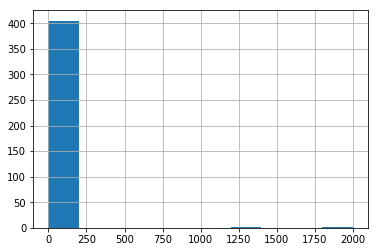

In [179]:
new_azdias_df.max().hist()
plt.show()

#### Scaling

Perform StandardScaler to best handle outliers.

In [180]:
scaler = StandardScaler()

In [181]:
scaler_new_azdias_df = pd.DataFrame(scaler.fit_transform(new_azdias_df.values), columns=new_azdias_df.columns, index=new_azdias_df.index)
scaler_new_customers_df = pd.DataFrame(scaler.fit_transform(new_customers_df.values), columns=new_customers_df.columns, index=new_customers_df.index)

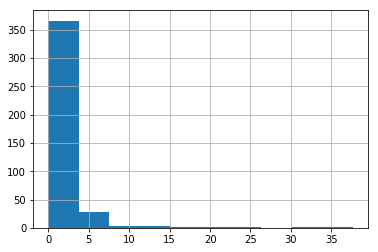

In [182]:
scaler_new_azdias_df.max().hist()
plt.show()

#### PCA

What we want to do here ...

* **PCA**: Use PCA to find how many components, `N_COMPONENTS`,will best describe total feature variance.
* **Dimensionality Reduction**: User `N_COMPONENTS` to create new simplified dataframe.

In [183]:
# Apply PCA by fitting the good data with the same number of dimensions as features
new_azdias_pca = PCA().fit(scaler_new_azdias_df)

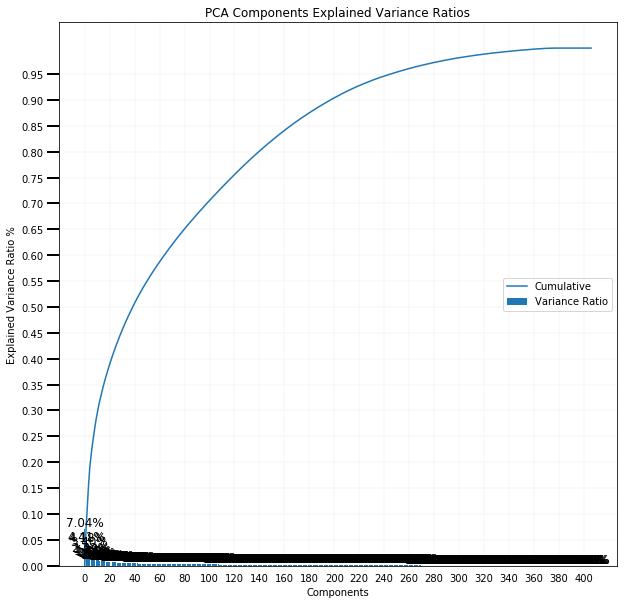

In [184]:
def show_pca(pca):
    """    
    INPUT:
        pca: an sklearn.decomposition.pca.PCA object    
    
    OUTPUT:
        None (visualizes a plot)
    
    DESCRIPTION:
        Visualize the curves of the explained variance ratio for each component and the cumulative ratios
    """
    num_components = len(pca.explained_variance_ratio_)
    cumulative_ratios = np.zeros(len(pca.explained_variance_ratio_))
    vals = pca.explained_variance_ratio_
    ind = np.arange(num_components)
    
    for i in range(num_components):
        cumulative_ratios[i]=np.sum(pca.explained_variance_ratio_[:i])
        
    plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    
    plt.bar(x=np.arange(len(pca.explained_variance_ratio_)), height=pca.explained_variance_ratio_)
    plt.plot(cumulative_ratios)
    
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]),
                    va="bottom", ha="center", fontsize=12)
    plt.xlabel("Components")
    plt.ylabel("Explained Variance Ratio %")
    plt.title("PCA Components Explained Variance Ratios")
    plt.yticks(np.arange(0, 1, step=0.05))
    plt.xticks(np.arange(0, len(pca.explained_variance_ratio_)+2, step=(len(pca.explained_variance_ratio_) // 20)))
    plt.tick_params(axis='x', width=0)
    plt.tick_params(axis='y', width=2, length=12)
    plt.grid(linewidth=0.1)
    plt.legend(['Cumulative', 'Variance Ratio'], loc='center right')
    
show_pca(new_azdias_pca)

We can use first 200 principal component to cover 90% variance.

In [185]:
sum(new_azdias_pca.explained_variance_ratio_[:200])

0.9038177125616197

In [186]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Dimension indexing
dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(new_azdias_pca.components_)+1)]

# PCA components
new_azdias_components_pca_df = pd.DataFrame(np.round(new_azdias_pca.components_, 4), columns = new_azdias_df.keys())
new_azdias_components_pca_df.index = dimensions

In [187]:
new_azdias_components_pca_df.head()

,AKT_DAT_KL,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_DHT4A_8.0,VK_DHT4A_9.0,VK_DHT4A_10.0,VK_DHT4A_11.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6
Dimension 1,0.0504,-0.0340,0.0061,0.1386,-0.0,-0.0305,-0.0807,0.0,0.0969,-0.0528,...,0.0164,0.0181,0.0531,0.0121,-0.0750,-0.0392,0.0262,0.0009,0.0426,0.0275
Dimension 2,0.0138,0.0122,-0.0002,0.0359,-0.0,-0.0110,-0.0117,0.0,-0.0287,-0.0976,...,0.0056,0.0101,-0.0011,-0.0010,0.0129,0.0042,-0.0008,-0.0122,-0.0077,0.0093
Dimension 3,0.0273,-0.1545,0.0050,0.0070,-0.0,0.0837,0.0663,-0.0,-0.0198,-0.0225,...,-0.0234,-0.0260,-0.0767,0.0082,0.0239,0.0292,-0.1574,0.1062,0.0729,-0.0105
Dimension 4,-0.0265,0.0795,-0.0171,0.0412,-0.0,0.0246,0.0977,-0.0,0.0324,-0.0830,...,-0.0131,-0.0212,-0.1220,-0.0045,0.0277,0.0159,-0.0357,0.0247,-0.0296,0.0114
Dimension 5,-0.1088,-0.0092,0.0540,-0.0256,-0.0,0.0205,0.0300,0.0,0.1293,0.0289,...,-0.0583,-0.0615,0.0695,-0.0134,-0.0105,0.0384,0.0568,-0.0162,-0.0402,-0.0466


#### First principal component

top 5 positive feature

In [188]:
top5_1st_pos = new_azdias_components_pca_df.iloc[0].sort_values(ascending=False)[:5]
top5_1st_pos

PLZ8_ANTG3             0.1392
KBA13_ANTG3            0.1390
ANZ_HAUSHALTE_AKTIV    0.1386
PLZ8_BAUMAX            0.1199
KBA13_ANTG4            0.1168
Name: Dimension 1, dtype: float64

top 5 negative feature

In [189]:
top5_1st_neg = new_azdias_components_pca_df.iloc[0].sort_values(ascending=False)[-1:-6:-1]
top5_1st_neg

PLZ8_ANTG1       -0.1399
KBA13_ANTG1      -0.1388
MOBI_RASTER      -0.1333
MOBI_REGIO       -0.1332
LP_STATUS_FEIN   -0.1312
Name: Dimension 1, dtype: float64

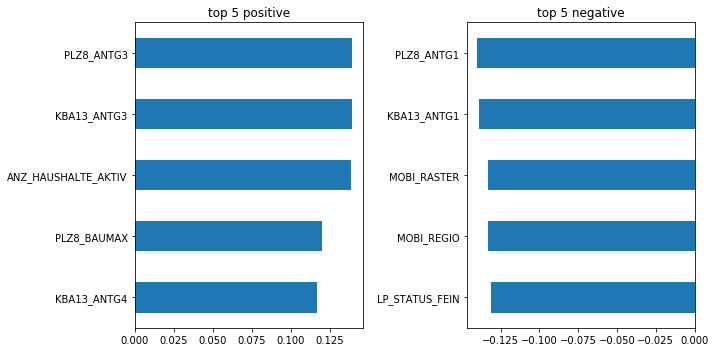

In [190]:
plt.figure(figsize=(10,5))

# top 5 positive feature
plt.subplot(1,2,1)
top5_1st_pos.sort_values(ascending=True).plot.barh()
plt.title('top 5 positive')

# top 5 negative feature
plt.subplot(1,2,2)
top5_1st_neg.sort_values(ascending=False).plot.barh()
plt.title('top 5 negative')

plt.tight_layout()
plt.show()

#### Second principal component

top 5 positive feature

In [191]:
top5_2nd_pos = new_azdias_components_pca_df.iloc[1].sort_values(ascending=False)[:5]
top5_2nd_pos

KBA13_HERST_BMW_BENZ           0.1811
KBA13_SEG_OBEREMITTELKLASSE    0.1548
KBA13_MERCEDES                 0.1543
KBA13_BMW                      0.1517
KBA13_SITZE_4                  0.1463
Name: Dimension 2, dtype: float64

tope 5 negative feature

In [192]:
top5_2nd_neg = new_azdias_components_pca_df.iloc[1].sort_values(ascending=False)[-1:-6:-1]
top5_2nd_neg

KBA13_SITZE_5          -0.1479
KBA13_KMH_140_210      -0.1296
KBA13_SEG_KLEINWAGEN   -0.1266
KBA13_HALTER_25        -0.1178
KBA13_HALTER_20        -0.1172
Name: Dimension 2, dtype: float64

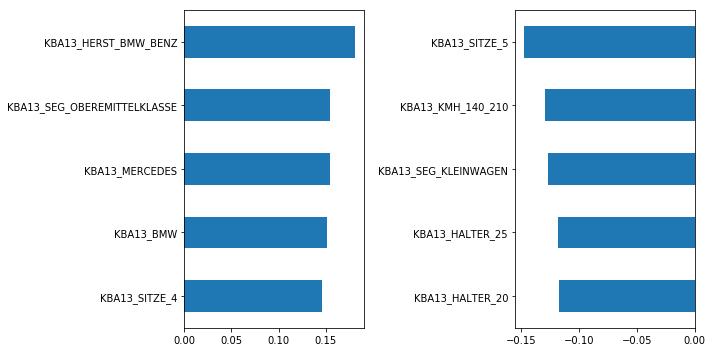

In [193]:
plt.figure(figsize=(10,5))

# top 5 positive feature
plt.subplot(1,2,1)
top5_2nd_pos.sort_values(ascending=True).plot.barh()

# top 5 negative feature
plt.subplot(1,2,2)
top5_2nd_neg.sort_values(ascending=False).plot.barh()

plt.tight_layout()
plt.show()

#### Third principal component

top 5 positive feature

In [194]:
top5_3rd_pos = new_azdias_components_pca_df.iloc[2].sort_values(ascending=False)[:5]
top5_3rd_pos

FINANZ_SPARER        0.1700
CJT_TYP_1            0.1696
CJT_TYP_2            0.1679
ONLINE_AFFINITAET    0.1616
SEMIO_TRADV          0.1565
Name: Dimension 3, dtype: float64

tope 5 negative feature

In [195]:
top5_3rd_neg = new_azdias_components_pca_df.iloc[2].sort_values(ascending=False)[-1:-6:-1]
top5_3rd_neg

CJT_TYP_5          -0.1719
CJT_TYP_4          -0.1718
CJT_TYP_3          -0.1695
FINANZ_VORSORGER   -0.1692
CJT_TYP_6          -0.1664
Name: Dimension 3, dtype: float64

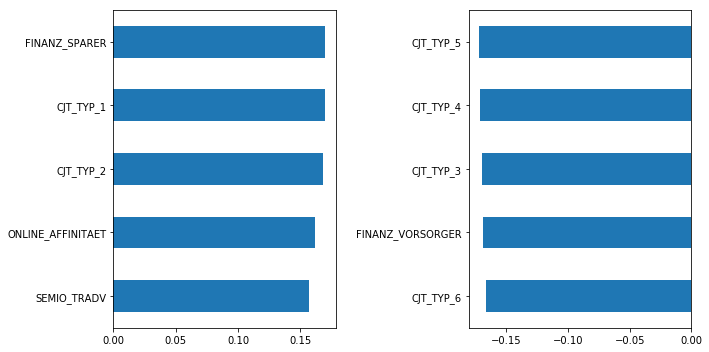

In [196]:
plt.figure(figsize=(10,5))

# top 5 positive feature
plt.subplot(1,2,1)
top5_3rd_pos.sort_values(ascending=True).plot.barh()

# tope 5 negative feature
plt.subplot(1,2,2)
top5_3rd_neg.sort_values(ascending=False).plot.barh()

plt.tight_layout()
plt.show()

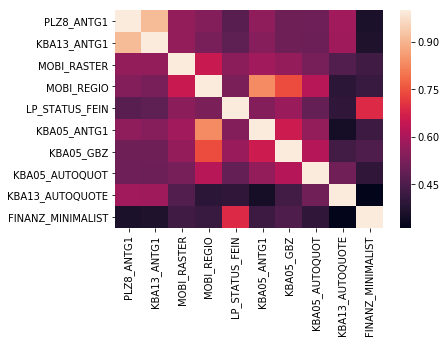

In [205]:
sns.heatmap(new_azdias_df[new_azdias_components_pca_df.iloc[0].sort_values(ascending=False)[-1:-11:-1].index.values].corr())

In [ ]:
new_azdias_components_pca_df.iloc[0].sort_values(ascending=False)[:10].index.values

In [ ]:
new_azdias_df[new_azdias_components_pca_df.iloc[0].sort_values(ascending=False)[:10].index.values].corr())

In [198]:
azdias_df[['KBA13_BAUMAX', 'PLZ8_BAUMAX']].corr()

,KBA13_BAUMAX,PLZ8_BAUMAX
KBA13_BAUMAX,1.000000,0.950527
PLZ8_BAUMAX,0.950527,1.000000


In [206]:
azdias_df[['PLZ8_ANTG1', 'KBA13_ANTG1']].corr()

,PLZ8_ANTG1,KBA13_ANTG1
PLZ8_ANTG1,1.00000,0.91886
KBA13_ANTG1,0.91886,1.00000


In [199]:
azdias_df[['PLZ8_ANTG3', 'KBA13_ANTG3']].corr()

,PLZ8_ANTG3,KBA13_ANTG3
PLZ8_ANTG3,1.000000,0.911774
KBA13_ANTG3,0.911774,1.000000


In [ ]:
azdias_df[['CJT_TYP_1', 'CJT_TYP_2']].corr()

In [200]:
azdias_df[['PLZ8_ANTG4', 'KBA13_ANTG4']].corr()

,PLZ8_ANTG4,KBA13_ANTG4
PLZ8_ANTG4,1.000000,0.899595
KBA13_ANTG4,0.899595,1.000000


#### Dimensionality Reduction

User `N_COMPONENTS` to create new simplified dataframe.

In [ ]:
N_COMPONENTS = 200 # first 200 principal component cover 95% variance.

# Apply PCA by fitting the good data with only 200 dimensions
new_azdias_pca = PCA(n_components=N_COMPONENTS).fit(scaler_new_azdias_df)

# Transform the general population using the PCA fit above
reduced_data_new_azdias = new_azdias_pca.transform(scaler_new_azdias_df)

# Transform the customer using the PCA fit above
reduced_data_new_customers = new_azdias_pca.transform(scaler_new_customers_df)

# Create a DataFrame for the reduced data
new_azdias_reduced_data_df = pd.DataFrame(reduced_data_new_azdias, columns = ['Dimension '+str(i) for i in range(1, N_COMPONENTS+1)])
new_customers_reduced_data_df = pd.DataFrame(reduced_data_new_customers, columns = ['Dimension '+str(i) for i in range(1, N_COMPONENTS+1)])

In [ ]:
new_azdias_reduced_data_df.head()

### Clustering

What we want to do here ...
* **Identidy cluster**: Use MiniBatchKMeans to fast find `N_CLUSTERS` for K-Meana algorithm.
* **Create cluster**: Apply K-Means with `N_CLUSTERS` to customer and general population,

#### Identify cluster

Use `MiniBatchKMeans` to fast find `N_CLUSTERS` for K-Meana algorithm.

In [ ]:
# Over a number of different cluster counts...
scores = []
centers = list(range(1,31))
for center in centers:
    
    # run MiniBatchKMeans clustering on the data
    kmeans = MiniBatchKMeans(n_clusters=center, random_state=27)
    model = kmeans.fit(reduced_data_new_azdias)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(reduced_data_new_azdias))
    scores.append(score)

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.

plt.figure(figsize=(10, 5))
ax = plt.subplot()
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.xticks(np.arange(1, 31, step=1))
plt.ylabel('SSE');
plt.title('SSE vs. K');

#### Create cluster

Apply K-Means with `N_CLUSTERS` to customer and general population,

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
N_CLUSTERS = 20  # After K = 20, SSE decrease is not so obvious

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=27, n_jobs=N_JOBS)

# train kmeans model
model_kmeans = kmeans.fit(reduced_data_new_azdias)

In [ ]:
# predict cluster of general population
azdias_preds = model_kmeans.predict(reduced_data_new_azdias)

In [ ]:
# pca reduced data with cluster information of general population
cluster_new_azdias_reduced_data_df = new_azdias_reduced_data_df
cluster_new_azdias_reduced_data_df['Cluster'] = azdias_preds # add cluster column
cluster_new_azdias_reduced_data_df.head()

In [ ]:
# predict cluster of customer
customers_preds = model_kmeans.predict(reduced_data_new_customers)

In [ ]:
# pca reduced data with cluster information of customer
cluster_new_customers_reduced_data_df = new_customers_reduced_data_df
cluster_new_customers_reduced_data_df['Cluster'] = customers_preds  # add cluster column
cluster_new_customers_reduced_data_df.head()

In [ ]:
cluster_new_azdias_reduced_data_df.shape, cluster_new_customers_reduced_data_df.shape

In [ ]:
plt.figure(figsize=(10, 5))

# Customer vs General polulation Cluster distribution
ax1 = plt.subplot(121)
pd.DataFrame({'Customer': pd.Series(customers_preds).value_counts()/customers_preds.size, 'General Population': pd.Series(azdias_preds).value_counts()/azdias_preds.size}).plot.bar(rot=0, ax=ax1)
plt.xlabel('cluster')
plt.ylabel('%').set_rotation(0)
plt.title('Customer vs General polulation Cluster distribution')

# Customer vs General polulation Cluster difference
ax2 = plt.subplot(122)
_ = (pd.Series(customers_preds).value_counts()/customers_preds.size - pd.Series(azdias_preds).value_counts()/azdias_preds.size).sort_values()
target_cluster = _.index[-1] # the most customer like clusters
non_target_cluster = _.index[0] # the most customer like clusters
_.plot.barh(ax=ax2)
plt.xlabel('% difference')
plt.ylabel('cluster')
plt.title('Customer vs General polulation Cluster difference')

plt.tight_layout()
plt.show()

In [ ]:
target_cluster, non_target_cluster

### Data Recovery

Map N cluster to original space. Then, select 2 cluster as target, for the most customer like, and non-target, the least customer like. Finally, compare over and under represented features between these 2 culsters.

In [ ]:
# add cluster and LNR to original data
inv_cluster_new_azdias_reduced_data_df = new_azdias_pca.inverse_transform(cluster_new_azdias_reduced_data_df.drop('Cluster', axis=1))
inv_cluster_new_azdias_reduced_data_df = pd.DataFrame(scaler.inverse_transform(inv_cluster_new_azdias_reduced_data_df), columns=new_azdias_df.columns)
inv_cluster_new_azdias_reduced_data_df.set_index(new_azdias_df.index, inplace=True)  # add LNR column
inv_cluster_new_azdias_reduced_data_df['Cluster'] = cluster_new_azdias_reduced_data_df['Cluster'].values  # add cluster column
inv_cluster_new_azdias_reduced_data_df.reset_index(inplace=True)
inv_cluster_new_azdias_reduced_data_df.head()

In [ ]:
# add cluster and LNR to original data
inv_cluster_new_customers_reduced_data_df = new_azdias_pca.inverse_transform(cluster_new_customers_reduced_data_df.drop('Cluster', axis=1))
inv_cluster_new_customers_reduced_data_df = pd.DataFrame(scaler.inverse_transform(inv_cluster_new_customers_reduced_data_df), columns=new_customers_df.columns)
inv_cluster_new_customers_reduced_data_df.set_index(new_customers_df.index, inplace=True)  # add LNR column
inv_cluster_new_customers_reduced_data_df['Cluster'] = cluster_new_customers_reduced_data_df['Cluster'].values  # add cluster column
inv_cluster_new_customers_reduced_data_df.reset_index(inplace=True)
inv_cluster_new_customers_reduced_data_df.head()

In [ ]:
# select cluster
target_cluster_new_customers_df = inv_cluster_new_customers_reduced_data_df[inv_cluster_new_customers_reduced_data_df['Cluster'] == target_cluster]
non_target_cluster_new_customers_df = inv_cluster_new_customers_reduced_data_df[inv_cluster_new_customers_reduced_data_df['Cluster'] == non_target_cluster]

target_cluster_new_customers_df.shape, non_target_cluster_new_customers_df.shape

In [ ]:
# select feature to compare
TARGET_COLUMNS = np.union1d(top5_1st_pos.index, top5_1st_neg.index)
TARGET_COLUMNS = np.union1d(TARGET_COLUMNS, top5_2nd_pos.index)
TARGET_COLUMNS = np.union1d(TARGET_COLUMNS, top5_2nd_neg.index)
TARGET_COLUMNS = np.union1d(TARGET_COLUMNS, top5_3rd_pos.index)
TARGET_COLUMNS = np.union1d(TARGET_COLUMNS, top5_3rd_neg.index)
TARGET_COLUMNS = np.intersect1d(TARGET_COLUMNS, annot_attr_azdias_values)  # only get documented feature
TARGET_COLUMNS

In [ ]:
# find mean value to compare difference of each cluster
target = target_cluster_new_customers_df[TARGET_COLUMNS].describe().loc['mean']
non_target = non_target_cluster_new_customers_df[TARGET_COLUMNS].describe().loc['mean']

# draw distribution bar chart
cluster_df = pd.concat([target, non_target], axis=1)
cluster_df.columns = ['Target', 'Non-target']
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(211)
cluster_df.plot.barh(ax=ax1)
plt.title('Target vs Non-target customer top {} feature distribution'.format(len(TARGET_COLUMNS)))

# draw difference bar chart
ax2 = plt.subplot(212)
(cluster_df['Target'] - cluster_df['Non-target']).sort_values().plot.barh(ax=ax2)
plt.title('Target vs Non-target customer top {} feature difference'.format(len(TARGET_COLUMNS)))

plt.tight_layout()
plt.show()

### Conclusion

* From above we can somehow come out the customer face as: less than 25 year old, small car owner, low income, no household, traditional mind, no luxury car, don't like online purchase,
* We already include LNR information in every cluster. Compony can send advertisement to most customer like general population.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [207]:
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/Users/fc/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [208]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


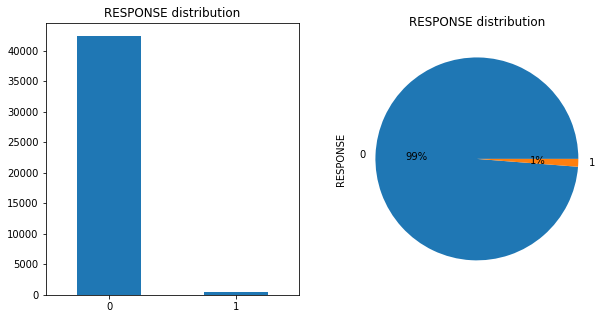

In [209]:
plt.figure(figsize=(10, 5))

# RESPONSE distribution bar chart
ax1 = plt.subplot(121)
mailout_train['RESPONSE'].value_counts().plot.bar(rot=0, ax=ax1)
plt.title('RESPONSE distribution')

# RESPONSE distribution pie chart
ax1 = plt.subplot(122)
mailout_train['RESPONSE'].value_counts().plot.pie(autopct='%1.f%%')
plt.title('RESPONSE distribution')

plt.show()

#### What we want to do here ...
In this section, we will apply `clean_data` created in part 0 to preprocess the data, and scale it. Use it to pick a best performance model, and tune the model performance.

* Data Cleaning
    - Perform data preprocessing with `clean_data` created in Part 0. And scale the data.
* Metrics Selection
    - Select the best metrics to measure performance.
* Model Selection
    - Select the best machine learning algorithm for the dataset.
* XGBoost Tuning
    - Fine-tune XGBoost hyperparameters.

### Data Cleaning
Perform data preprocessing with `clean_data` created in Part 0. And scale the data.

In [213]:
new_mailout_train_df = clean_data(mailout_train.copy())

mix_cat...
drop...
log_transform...


/Users/fc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


cap outlier...


/Users/fc/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


cover...
ANZ_PERSONEN in general population have min value: 0.6931471805599453 larger than sample: 0.0 -> drop
ANZ_PERSONEN in general population have max value: 1.6094379124341003 smaller than sample: 1.791759469228055 -> drop
fillna...


/Users/fc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/fc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


onehot...
clean_data successfully :)


In [214]:
new_mailout_train_df.head()

,AKT_DAT_KL,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_DHT4A_8.0,VK_DHT4A_9.0,VK_DHT4A_10.0,VK_DHT4A_11.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6
LNR,,,,,,,,,,,,,,,,,,,,,
1763,1.0,4,2,2.772589,0.0,0.0,0.693147,0.0,3.0,5.0,...,0,0,0,0,0,0,1,0,0,0
1771,4.0,3,2,0.693147,0.0,0.0,1.098612,0.0,2.0,5.0,...,0,0,0,0,1,0,0,0,0,0
1776,1.0,4,1,0.693147,0.0,0.0,1.098612,0.0,4.0,1.0,...,0,0,0,0,0,0,1,0,0,0
1460,1.0,4,2,1.609438,0.0,0.0,1.098612,0.0,4.0,2.0,...,1,0,0,0,0,0,1,0,0,0
1783,1.0,3,1,3.295837,0.0,0.0,0.693147,0.0,3.0,4.0,...,0,0,0,0,0,0,1,0,0,0


In [215]:
if DEBUG:
    new_mailout_train_df.to_pickle('new_mailout_train_df.pickle')

In [216]:
if DEBUG:
    new_mailout_train_df = pd.read_pickle("new_mailout_train_df.pickle")

In [217]:
y_train = new_mailout_train_df['RESPONSE']
X_train = new_mailout_train_df.drop(['RESPONSE'], axis=1)

# scaling
X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)  # scaling

X_train.shape, y_train.shape

((42962, 407), (42962,))

### Metrics Selection

* With imbalanced classes, it’s easy to get a high accuracy without actually making useful predictions. So, accuracy as an evaluation metrics makes sense only if the class labels are uniformly distributed.
* In this case, we would like to use [AUC for the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve), Which is match with Kaggle model evaluation method.

### Model Selection
Select the best machine learning algorithm for the dataset.

In [218]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.
        
    axes : matplotlib.axes

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes == None:
        plt.figure()
    else:
        plt.axes = axes
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring='roc_auc', cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

__NOTE__: The `plot_learning_curve` function is used to draw learning curve. Which is inspired by [Plotting Learning Curves](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html).

We would like to use [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) to handle inbalance data.

In [219]:
# Initialize 5 StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=5, random_state=27)

We select below type of algorithms to compare their performance. And found XGBoost is the best one.
* DecisionTreeClassifier
* LinearSVC
* AdaBoostRegressor
* XGBRegressor

In [ ]:
clf_A = DecisionTreeClassifier(random_state=27)
clf_B = LinearSVC(random_state=27)
clf_C = AdaBoostRegressor(random_state=27)
clf_D = XGBRegressor(random_state=27)

In [ ]:
plt.figure(figsize=(10, 5))

# DecisionTreeClassifier
ax1 = plt.subplot(2,2,1)
plot_learning_curve(clf_A, 'DecisionTreeClassifier', X_train, y_train, axes=ax1, ylim=(0.5, 1), cv=cv, n_jobs=N_JOBS)

# LinearSVC
ax2 = plt.subplot(2,2,2)
plot_learning_curve(clf_B, 'LinearSVC', X_train, y_train, axes=ax2, ylim=(0.5, 1), cv=cv, n_jobs=N_JOBS)

#　AdaBoostRegressor
ax3 = plt.subplot(2,2,3)
plot_learning_curve(clf_C, 'AdaBoostRegressor', X_train, y_train, axes=ax3, ylim=(0.5, 1), cv=cv, n_jobs=N_JOBS)

# XGBRegressor
ax4 = plt.subplot(2,2,4)
plot_learning_curve(clf_D, 'XGBRegressor', X_train, y_train, axes=ax4, ylim=(0.5, 1), cv=cv, n_jobs=N_JOBS)

plt.tight_layout()
plt.show()

### XGBoost Tuning
Fine-tune XGBoost hyperparameters.
* Tune max_depth and min_child_weight
* Tune gamma
* Tune subsample and colsample_bytree
* Tune Regularization Parameters
* Reduce Learning Rate

__NOTE__: The complete procedure for XGBoot tuning is inspired by [Complete Guide to Parameter Tuning in XGBoost with codes in Python](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/).

#### Fix learning rate and number of estimators for tuning tree-based parameters

In [220]:
def modelfit(alg, X, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, stratified=True, seed=27, verbose_eval=20)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values()[-20:]

    feat_imp.plot(kind='barh', title='Top 20 Feature Importance Score')
    plt.tight_layout()
    plt.show()

[0]	train-auc:0.761331+0.00357839	test-auc:0.754866+0.0137423
[20]	train-auc:0.811337+0.00554927	test-auc:0.75609+0.0121389
[40]	train-auc:0.881807+0.00598001	test-auc:0.758365+0.00484197

Model Report
Accuracy : 0.9876
AUC Score (Train): 0.781624


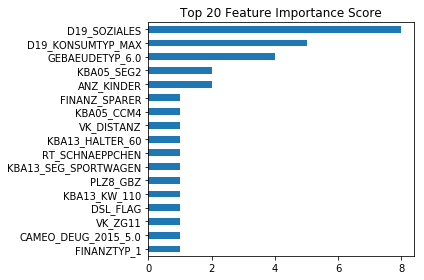

In [240]:
# try to train model
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    n_estimators=5000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    n_jobs=N_JOBS,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb_clf, X_train, y_train)

[0]	train-auc:0.752569+0.0183503	test-auc:0.746784+0.0165234
[20]	train-auc:0.777817+0.00786507	test-auc:0.75492+0.011345
[40]	train-auc:0.812603+0.0013494	test-auc:0.757822+0.0104172
[60]	train-auc:0.850012+0.0022927	test-auc:0.762496+0.00677444
[80]	train-auc:0.87757+0.000902616	test-auc:0.75989+0.00967211
[100]	train-auc:0.897133+0.00117414	test-auc:0.759202+0.00763781

Model Report
Accuracy : 0.9876
AUC Score (Train): 0.841444


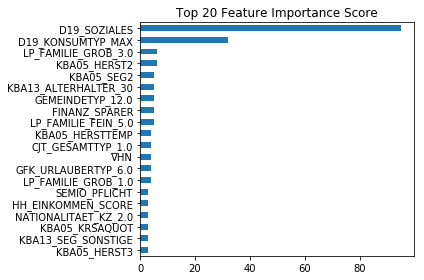

In [267]:
# try to train model
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    n_jobs=N_JOBS,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb_clf, X_train, y_train)

#### Tune max_depth and min_child_weight####


Tried `max_depth`: [3, 5, 7, 9], and `min_child_weight`: [1, 3, 5] combination with 2 unit step.

In [241]:
param_test = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch = GridSearchCV(
    estimator=XGBClassifier(
        learning_rate=0.1,
        n_estimators=140, 
        max_depth=5,
        min_child_weight=1, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective='binary:logistic',
        n_jobs=N_JOBS, 
        scale_pos_weight=1, 
        seed=27), 
     param_grid=param_test, scoring='roc_auc',n_jobs=N_JOBS,iid=False, cv=cv)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'max_depth': 3, 'min_child_weight': 5}, 0.7603831380150446)

We already find `min_child_weight`: 5. We will continue to tried `max_depth`: 1 ~ 4 with 1 unit step.

In [242]:
param_test = {
    'max_depth':range(1,4,1),
}
gsearch = GridSearchCV(
    estimator=XGBClassifier(
        learning_rate =0.1,
        n_estimators=140, 
        max_depth=5,
        min_child_weight=5,  # min_child_weight = 5
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective='binary:logistic',
        n_jobs=N_JOBS, 
        scale_pos_weight=1, 
        seed=27), 
    param_grid=param_test, scoring='roc_auc', n_jobs=N_JOBS, iid=False, cv=cv)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'max_depth': 3}, 0.7603831380150446)

Find out 'max_depth': 3 is the best.

Until now, we have below optimized hyperparameters.
* max_depth: 3
* min_child_weight: 5

#### Tune gamma
Tried gamma for .1 to .5.

In [243]:
param_test = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch = GridSearchCV(
    estimator=XGBClassifier(
        learning_rate=0.1,
        n_estimators=140, 
        max_depth=3,  # max_depth = 3
        min_child_weight=5,  # min_child_weight = 5 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective='binary:logistic',
        n_jobs=N_JOBS, 
        scale_pos_weight=1, 
        seed=27), 
    param_grid=param_test, scoring='roc_auc', n_jobs=N_JOBS, iid=False, cv=cv)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'gamma': 0.0}, 0.7603831380150446)

Find 'gamma': .2 is the best.

Until now, we have below optimized hyperparameters.
* max_depth: 3
* min_child_weight: 5
* gamma: .2

[0]	train-auc:0.76095+0.00356966	test-auc:0.75463+0.0135183
[20]	train-auc:0.783645+0.00370893	test-auc:0.760968+0.0148536
[40]	train-auc:0.809852+0.00248723	test-auc:0.763309+0.00859555
[60]	train-auc:0.833699+0.00162506	test-auc:0.761628+0.00880108
[80]	train-auc:0.85895+0.00218978	test-auc:0.764631+0.0103914
[100]	train-auc:0.877366+0.00128094	test-auc:0.765878+0.00698119
[120]	train-auc:0.891332+0.00102657	test-auc:0.762625+0.00658816
[140]	train-auc:0.903355+0.00150766	test-auc:0.759524+0.0075697

Model Report
Accuracy : 0.9876
AUC Score (Train): 0.864819


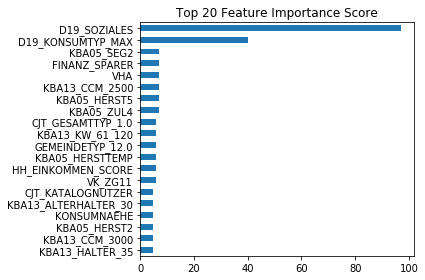

In [244]:
# try to train model
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=3,
    min_child_weight=5,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    n_jobs=N_JOBS,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb_clf, X_train, y_train)

#### Tune subsample and colsample_bytree
Tried `subsample`: .6 ~ 1, and `colsample_bytree`: .6 ~ 1 combination.

In [245]:
param_test = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch = GridSearchCV(
    estimator=XGBClassifier(
        learning_rate=0.1,
        n_estimators=140, 
        max_depth=3,  # max_depth = 3
        min_child_weight=5,  # min_child_weight = 5 
        gamma=0,  # gamma = 0.2
        subsample=0.8, 
        colsample_bytree=0.8,
        objective='binary:logistic',
        n_jobs=N_JOBS, 
        scale_pos_weight=1, 
        seed=27), 
    param_grid = param_test, scoring='roc_auc',n_jobs=N_JOBS,iid=False, cv=cv)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.7603831380150446)

Find `colsample_bytree` = .8 and `subsample` = .8 is the best.

Continue to tried `subsample` from .7 to .9 and `colsample_bytree` from .7 to .9 with .05 unit step.

In [246]:
param_test = {
    'subsample':[i/100.0 for i in range(70,90,5)],
     'colsample_bytree':[i/100.0 for i in range(70,90,5)]
}
gsearch = GridSearchCV(
    estimator=XGBClassifier(
        learning_rate=0.1,
        n_estimators=140, 
        max_depth=3,  # max_depth = 3
        min_child_weight=5,  # min_child_weight = 5 
        gamma=0,  # gamma = 0.2
        subsample=0.8, 
        colsample_bytree=0.8,
        objective='binary:logistic',
        n_jobs=N_JOBS, 
        scale_pos_weight=1, 
        seed=27), 
    param_grid=param_test, scoring='roc_auc',n_jobs=N_JOBS,iid=False, cv=cv)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.7603831380150446)

Find `colsample_bytree` = .8 and `subsample` = .8 is the best.

Until now, we have below optimized hyperparameters.
* max_depth: 3
* min_child_weight: 5
* gamma: 0.2
* subsample': 0.8
* colsample_bytree: 0.8

#### Tune Regularization Parameters
Tried `reg_alpha`: [1e-5, 1e-2, 0.1, 1, 100]

In [247]:
param_test = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch = GridSearchCV(
    estimator=XGBClassifier(
        learning_rate=0.1,
        n_estimators=140, 
        max_depth=3,  # max_depth = 3
        min_child_weight=5,  # min_child_weight = 5 
        gamma=0,  # gamma = 0.2
        subsample=0.8,  # subsample': 0.8
        colsample_bytree=0.8,  # colsample_bytree = 0.8
        objective='binary:logistic',
        n_jobs=N_JOBS, 
        scale_pos_weight=1, 
        seed=27), 
    param_grid=param_test, scoring='roc_auc',n_jobs=N_JOBS,iid=False, cv=cv)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'reg_alpha': 0.1}, 0.76103577970231)

1e-05 is the best. Continue to tried 0 and 1e-05.

In [248]:
param_test = {
    'reg_alpha':[0, 0.01, 0.05, 0.1, 0.5]
}
gsearch = GridSearchCV(
    estimator=XGBClassifier(
        learning_rate=0.1,
        n_estimators=140, 
        max_depth=3,  # max_depth = 3
        min_child_weight=5,  # min_child_weight = 5 
        gamma=0,  # gamma = 0.2
        subsample=0.8,  # subsample': 0.8
        colsample_bytree=0.8,  # colsample_bytree = 0.8
        objective='binary:logistic',
        n_jobs=N_JOBS, 
        scale_pos_weight=1, 
        seed=27), 
    param_grid=param_test, scoring='roc_auc', n_jobs=N_JOBS,iid=False, cv=cv)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'reg_alpha': 0.1}, 0.76103577970231)

Find `reg_alpha`: 0 is the best.

Until now, we have below optimized hyperparameters.
* max_depth: 3
* min_child_weight: 5
* gamma: 0.2
* subsample': 0.8
* colsample_bytree: 0.8
* reg_alpha: 0

[0]	train-auc:0.76095+0.00356966	test-auc:0.75463+0.0135183
[20]	train-auc:0.781127+0.00361559	test-auc:0.761544+0.014824
[40]	train-auc:0.809389+0.00224416	test-auc:0.762709+0.00880624
[60]	train-auc:0.832846+0.00261775	test-auc:0.761683+0.00882467
[80]	train-auc:0.858071+0.00258033	test-auc:0.764594+0.0107014
[100]	train-auc:0.876639+0.00135111	test-auc:0.763961+0.00873781
[120]	train-auc:0.891207+0.00120491	test-auc:0.763708+0.00646263

Model Report
Accuracy : 0.9876
AUC Score (Train): 0.854944


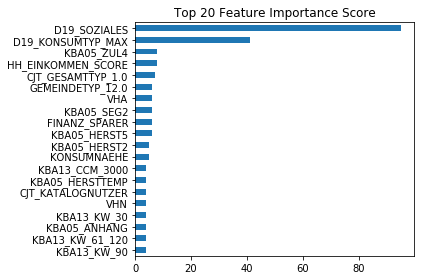

In [249]:
# try to train model
xgb_clf = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=3,  # max_depth = 3
    min_child_weight=5,  # min_child_weight = 5 
    gamma=0,  # gamma = 0.2
    subsample=0.8,  # subsample': 0.8
    colsample_bytree=0.8,  # colsample_bytree = 0.8
    reg_alpha=0.1,  # reg_alpha = 0
    objective= 'binary:logistic',
    n_jobs=N_JOBS,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb_clf, X_train, y_train)

#### Reduce Learning Rate
Manually try `learning_rate` and find .11 is the best.

[0]	train-auc:0.76095+0.00356966	test-auc:0.75463+0.0135183
[20]	train-auc:0.780173+0.00251298	test-auc:0.76068+0.0159988
[40]	train-auc:0.807197+0.00359711	test-auc:0.762889+0.00688006
[60]	train-auc:0.824326+0.0011148	test-auc:0.761325+0.00770867
[80]	train-auc:0.849762+0.00103012	test-auc:0.763377+0.00734583
[100]	train-auc:0.869011+0.00128944	test-auc:0.765572+0.00611527
[120]	train-auc:0.883324+0.000816941	test-auc:0.763989+0.0059795
[140]	train-auc:0.894778+0.00153682	test-auc:0.761288+0.00796366

Model Report
Accuracy : 0.9876
AUC Score (Train): 0.856993


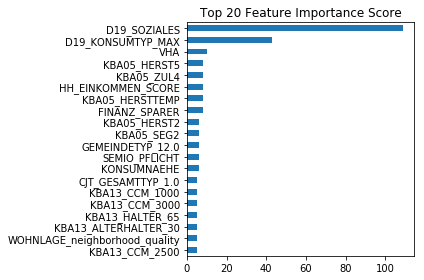

In [256]:
# try to train model
xgb_clf = XGBClassifier(
    learning_rate=0.09,
    n_estimators=5000,
    max_depth=3,  # max_depth = 3
    min_child_weight=5,  # min_child_weight = 5
    gamma=0,  # gamma = 0.2
    subsample=0.8,  # subsample': 0.8
    colsample_bytree=0.8,  # colsample_bytree = 0.8
    reg_alpha=0.1,  # reg_alpha = 0
    objective= 'binary:logistic',
    n_jobs=N_JOBS,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb_clf, X_train, y_train)

After hyperparameter tuning, the final AUC score is 0.81.

The most important feature is D19_SOZIALES by a large margin over the others. Unfortunately we don't have the description of this variable. Then the second one is D19_KONSUMTYP_MAX. We also have it's information. It maybe related to consumption type. SEMIO_PFLICHT is to indicate the person have a traditional mind. FINANZ_SPARER is an indicator to money saver. HH_EINKOMMEN_SCORE is to indicator of household income. KBA05_HERST2 is Audi car owner. So, company should focus on if the customer have a traditional mind, money saver, household income, or luxury car owner.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [225]:
mailout_test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/Users/fc/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [226]:
mailout_test.shape

(42833, 366)

In [257]:
# data preprocessing
new_mailout_test_df = clean_data(mailout_test.copy())

mix_cat...
drop...
log_transform...


/Users/fc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


cap outlier...


/Users/fc/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


cover...
ANZ_PERSONEN in general population have min value: 0.6931471805599453 larger than sample: 0.0 -> drop
ANZ_PERSONEN in general population have max value: 1.6094379124341003 smaller than sample: 1.791759469228055 -> drop
fillna...


/Users/fc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/fc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


onehot...
clean_data successfully :)


In [258]:
new_mailout_test_df.head()

,AKT_DAT_KL,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_DHT4A_8.0,VK_DHT4A_9.0,VK_DHT4A_10.0,VK_DHT4A_11.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6
LNR,,,,,,,,,,,,,,,,,,,,,
1754,1.0,4,1,1.098612,0.0,0.0,1.098612,0.0,3.0,6.0,...,0,0,0,0,0,0,1,0,0,0
1770,1.0,4,1,3.044522,0.0,0.0,0.693147,0.0,4.0,7.0,...,0,0,0,0,0,0,1,0,0,0
1465,9.0,4,2,1.098612,0.0,0.0,1.609438,0.0,4.0,1.0,...,0,1,0,0,0,0,1,0,0,0
1470,7.0,4,2,0.693147,0.0,0.0,1.098612,0.0,4.0,1.0,...,0,0,0,0,0,0,1,0,0,0
1478,1.0,4,2,0.693147,0.0,0.0,1.609438,0.0,3.0,6.0,...,0,0,0,0,0,0,0,1,0,0


In [259]:
if DEBUG:
    new_mailout_test_df.to_pickle('new_mailout_test_df.pickle')

In [260]:
if DEBUG:
    new_mailout_test_df = pd.read_pickle("new_mailout_test_df.pickle")

In [261]:
X_test = new_mailout_test_df

# scaling
X_test = pd.DataFrame(scaler.fit_transform(X_test.values), columns=X_test.columns, index=X_test.index)  # scaling

X_test.shape

(42833, 407)

In [262]:
# prediction
y_predict = xgb_clf.predict_proba(X_test)
y_predict[:,1]

array([0.02968202, 0.04859099, 0.00542088, ..., 0.02593583, 0.04016152,
       0.01602709], dtype=float32)

In [263]:
# generate prediction file: kaggle_predictions.txt
pd.DataFrame(index=mailout_test.LNR, data=y_predict[:, 1], columns=['RESPONSE']).to_csv("kaggle_predictions.txt")

In [264]:
pd.read_csv('kaggle_predictions.txt').head()

,LNR,RESPONSE
0,1754,0.029682
1,1770,0.048591
2,1465,0.005421
3,1470,0.003122
4,1478,0.003036


In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Arvato Project Workbook.ipynb'])